In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from scipy import optimize
from scipy import integrate
from scipy.signal import find_peaks
from scipy.integrate import simpson
from scipy.integrate import quad
from pathlib import Path
from os import listdir, chdir
from os.path import isfile, join
import regex as re
from lmfit import Model
from lmfit.models import LinearModel, GaussianModel, ExponentialModel, ConstantModel, PowerLawModel, PolynomialModel, LorentzianModel, VoigtModel
import math
import time
import itertools as it

In [2]:
def make_dataframe(sample_name, data_path):
    
    #INPUT - Set the path to the output files from the I vs q script - Use absolute path
    #data_path = r'C:\Users\Elizabeth\APS Spring 2022\Data Processing\Test_data\Sample6b_charge_dbl\Ivsq_text'
    #os.chdir(data_path)
    
    # Importing integrated XRD pattern from APS synchrotron expierment in Fall 2021 at beamline 5-BM-C
    file = open(os.path.join(data_path, sample_name))
    data = pd.read_csv(file, skiprows = 13, header = None, delim_whitespace=True)
    df = pd.DataFrame(data)
    df.columns = ['q','I']
        
    return df

In [3]:
def get_xy_motor(sample_name, data_path):

    try:
        # Find the x_motor position in the file title using Regex
        start_x = re.search('_x_', sample_name).end()
        end_x = re.search('mm_primary', sample_name).start() 
        x_motor = sample_name[start_x:end_x].replace(',', '.')
        x_motor = float(x_motor)

        # Find the y_motor position in the file title using Regex
        start_y = re.search('_y_', sample_name).end()
        end_y = re.search('mm_sample_x', sample_name).start()
        y_motor = sample_name[start_y:end_y].replace(',', '.')
        y_motor = float(y_motor)
    
    except AttributeError:
        print('oh shit bra, the name changed! (function could not find x and y position in file name)')
        x_motor = input('Whats the x value?')
        x_motor = float(x_motor)
        
        y_motor = input('Whats the y value?')
        y_motor = float(y_motor)
        print("Groovie.")
    
    return x_motor, y_motor


In [4]:
def get_points(df,q_min,q_max):
    
    ''' This function creates a condensed dataframe that isolates the deired peak
    Inputs: data set in data frame (df), lower q bound for peak(q_min), upper q bound for peak(q_max)
    Outputs: shortened dataframe (df_cut)'''
    
    return df[(df['q'] >= q_min) & (df['q'] <= q_max)]


In [5]:
def make_model(q_max, q_min, model_centers, sig, amp):
    background = LinearModel(prefix=('b' + '_'))  
    pars = background.make_params()
    
    model = background
    
    # initial guesses     
    slope1 = 0 
    int1 = 50
    
    # For linear background
    pars = background.make_params()
    pars['b' + '_slope'].set(slope1)
    pars['b' + '_intercept'].set(int1)
    
    for peak, center in enumerate(model_centers):
        # create prefex for each peak
        pref = 'g'+str(peak)+'_'
        peak = GaussianModel(prefix=pref)
        # set the parimiters for each peak
        pars.update(peak.make_params())
        pars[pref+'center'].set(value=center, min=q_min, max=q_max)
        pars[pref+'sigma'].set(value=sig, max = 0.05)
        pars[pref+'amplitude'].set(amp, min = 0)
        
        model = model + peak

    return (model, pars)
        

In [6]:
def get_model_list(df_cut, q_max, q_min, num_of_centers, num_peaks, sig, amp, peak_name, Li_q_max, Li_q_min):
    # set some inital parimiters if its lithium we want to narrow the range it will guess for peaks
    if peak_name == 'Li':
        temp_max = q_max
        temp_min = q_min
        q_max = Li_q_max
        q_min = Li_q_min
    # generate a list of centers to try
    increment = (q_max - q_min) / num_of_centers
    n = 0
    center_list = []
    
    while n <= num_of_centers:
        center_list.append(n*increment + q_min)
        n += 1
    q_range = q_max - q_min
    
    if peak_name != 'Li':
        center_list[0] = center_list[0] + .1 * q_range
        # -1 refers to the last element in the list
        center_list[-1] = center_list[-1] - .1 * q_range
    
    # creat unique combination of peak positions returns a list of tuples. 
    # Tuples are samp length of num_peaks
    center_list = list(it.combinations(center_list, num_peaks))
    
    # if its lithium we now need to reset the q max/mmin so the model will look at the whole range
    if peak_name == 'Li':
        q_max = temp_max
        q_min = temp_min
    
    # make a list of models for each center
    model_list = []
    for center in center_list:
        model_list.append(make_model(q_max, q_min, center, sig, amp))
    
    return(model_list)  
       

In [7]:
def run_model(df_cut, model, pars):
    model_result = model.fit(df_cut['I'], pars, x = df_cut['q'], nan_policy = 'omit')
    return(model_result)

In [16]:
def user_model(best_model, df_cut, sig, amp):
    good = 'n'
    print("\n\n fit not found")
    print('The chisqr is ', best_model.chisqr)
    best_model.plot()
    plt.pause(1)
    
    good = input('if its good enter y\n')
    
    while good != 'y':  
        try:
            centers =  input('Enter peak centers separated by comma \n')
            centers = centers.split(',')
            for i in range(len(centers)):
                # convert each item to int type
                centers[i] = float(centers[i])
            print(centers)
            # make_model(q_max, q_min, model_centers, sig, amp):
            model = make_model(q_max, q_min, centers, sig, amp)
            best_model = run_model(df_cut, model[0], model[1])
            print("chisqr is ", best_model.chisqr)
            best_model.plot()
            plt.pause(1)
            good = input('enter y to continue. To try again enter n.\n')
        except:
            print('operation filed with the following messege')
            print('Note for Ben. Add function so this prints error message. Also Hope your science is going well!')
    return best_model

In [15]:
def fit_data(df_cut, q_max, q_min, num_of_centers, sig, amp, chisqu_fit_value, peak_name, Li_q_max, Li_q_min):
    chisqr = 1000000000
    num_peaks = 1
    more_peaks = False
    #assign the max number of peaks allowed (1 plus that number so if there can be 3 peaks put 4 here)
    if peak_name == 'NMC':
        max_peak_allowed = 2
    else:
        max_peak_allowed = 4
    while chisqr >= chisqu_fit_value:

        if more_peaks is True and num_peaks >= max_peak_allowed:
            #print("TURN THE USER FIT BACK ON BEN")
            best_model = user_model(best_model, df_cut, sig, amp)
            print('chi squared: ' + str(chisqr))
            return best_model
        
        if num_peaks >= max_peak_allowed:
            num_peaks = 1
            num_of_centers = num_of_centers*2
            more_peaks = True
            print("THE THING HAPPENED MORE PEAKS")
 
            
        # returns a list of tuples. first value is the model second value is the pars. 
        # looks like this ((model, pars), (model, pars), ........)
        model_list = get_model_list(df_cut, q_max, q_min, num_of_centers, num_peaks, sig, amp, peak_name,
                                    Li_q_max, Li_q_min)
        
        model_result_list = []

        for i in range(len(model_list)):
            model = model_list[i][0]
            pars = model_list[i][1]
            model_result_list.append(run_model(df_cut, model, pars))
            
        results_sorted = sorted(model_result_list, key=lambda model: model.chisqr)
        best_model = results_sorted[0]
        chisqr = best_model.chisqr
        num_peaks += 1
        
    #best_model.plot()
    plt.pause(1)
    return best_model

In [10]:
def get_values(best_model, df_cut):
         
    # a list of tuples with 4 values. the peak data, fwhm, and center.
    # Looks like ((peak_data, fwhm, center, guess), (peak_data, fwhm, center, guess), ........)
    comps_list = []
    comps = best_model.eval_components(x=df_cut['q'])
    
  #  ax.plot(x,best_model, label='Model')
    for prefex in comps.keys():
        if prefex != 'b_':
            comps_list.append(((comps[str(prefex)]), best_model.params[str(prefex)+'fwhm'].value, best_model.params[str(prefex)+'center'].value, 1.75))
    
    integral_list = []
    fwhm_list = []
    peak_center_list = []
    
    for vals in comps_list:
        integral_val = integrate_model(df_cut, vals[0], vals[2], vals[3])
        integral_list.append(integral_val)
        # get_fwhm_center function not needed
        # fwhm_list, peak_center_list = get_fwhm_center(integral_val, vals[1], vals[2], vals[3])
        fwhm_list.append(vals[1])
        peak_center_list.append(vals[2])
        
    return integral_list, fwhm_list, peak_center_list
    

In [11]:
def integrate_model(df_cut, Gaussian, center_raw, q_guess):
    
    # Define model
    Model = Gaussian
    
    # Select the data to integrate over
    q_range = df_cut['q'].tolist()
    

    # Caclulate the integral based on the direct data using Simpson's rule
    integral = integrate.simpson(Model, q_range, even='avg')
    return integral

In [12]:
def save_fits(savePath_gen, get_integrals, element, list_of_files, i, sample_name):
    # find the cordanets of the sample and get rid of the dots file paths don't like that
    coordinates = (str(get_integrals[1]) + '_' + str(get_integrals[2])).replace('.', '-')
    # make it a file path
    savePath = os.path.join(savePath_gen, sample_name, element, coordinates)
    
    # if that foulder dosn't exist make it exist
    if not os.path.exists(savePath):
        os.makedirs(savePath)

    # name the file
    #y = str(i)
    #file_name = str(list_of_files[i])
    #file_name = file_name.replace(",", "_")
    #file_name = file_name[:len(file_name) - 5]
    file_name = sample_name
    fig_path = os.path.join(savePath, file_name)
    # save the file! that wasn't at all convaluded was it?
    get_integrals[6].plot().savefig(fig_path)
    plt.close()

In [13]:
def master_function(read_sample_file, num_of_centers,  data_path, q_min, q_max,  sample_name, sig, amp, chisqu_fit_value, peak_name, Li_q_max, Li_q_min):
    
    # Make a dataframe of the entire XRD pattern
    df = make_dataframe(read_sample_file, data_path)
    # Get xy_motor positions
    x_motor, y_motor = get_xy_motor(read_sample_file, data_path)
    
    # Slice the dataframe to desired q range
    df_cut = get_points(df, q_min, q_max)

    # get the best fit for the data
    best_model = fit_data(df_cut, q_max, q_min, num_of_centers, sig, amp, chisqu_fit_value, peak_name, Li_q_max, Li_q_min)

    if best_model is not None:
        integral_list, fwhm_list, peak_center_list = get_values(best_model, df_cut)
    else:
        return sample_name, x_motor, y_motor
    
    return [sample_name, x_motor, y_motor, integral_list, fwhm_list, peak_center_list, best_model]

finding  LiC6  peaks! Hold on to your socks!
qmax is  1.6 q min is  1.75
0
Figure(640x640)
chisqr is  9.317244686072968
x_motor and y motor are: (89.0,71.0)
peak centers:  [1.6830716891569655]


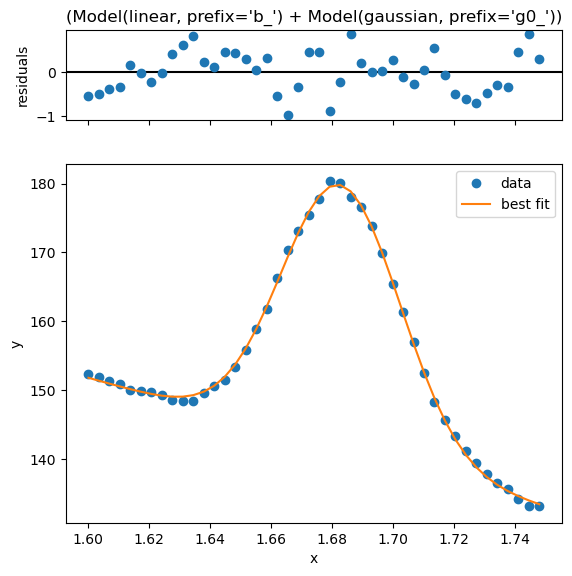

1
Figure(640x640)
chisqr is  7.535801984590258
x_motor and y motor are: (88.5,65.5)
peak centers:  [1.683956267908816]


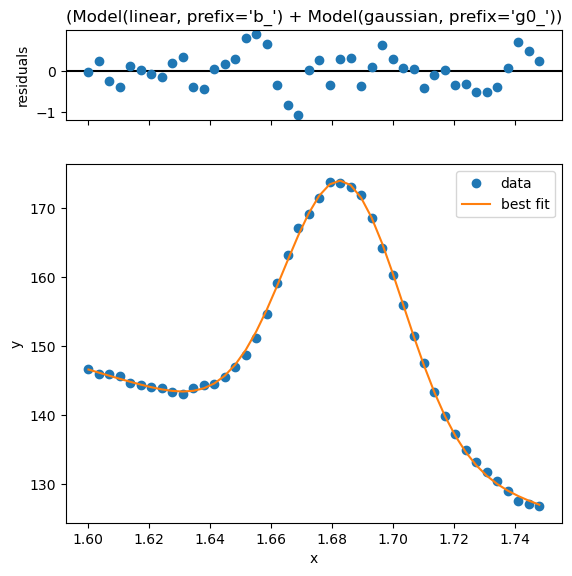

2
Figure(640x640)
chisqr is  9.8446739865863
x_motor and y motor are: (92.0,69.5)
peak centers:  [1.6833801912955209]


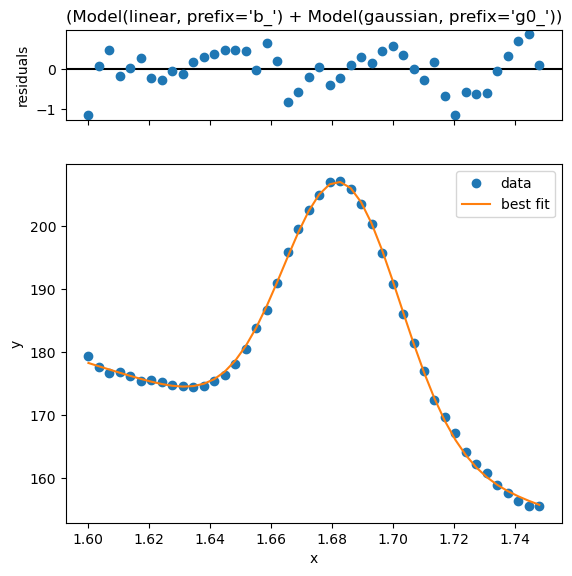

3
Figure(640x640)
chisqr is  6.434904855789859
x_motor and y motor are: (92.0,67.5)
peak centers:  [1.6839867420408363]


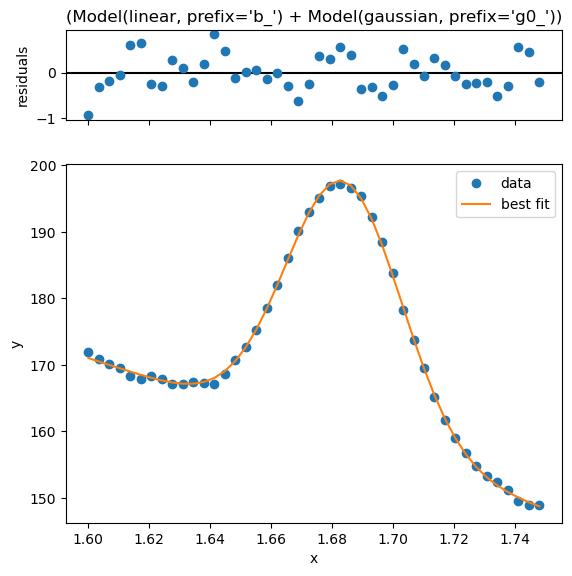

4
Figure(640x640)
chisqr is  8.271110393866097
x_motor and y motor are: (89.5,70.5)
peak centers:  [1.683356461639187]


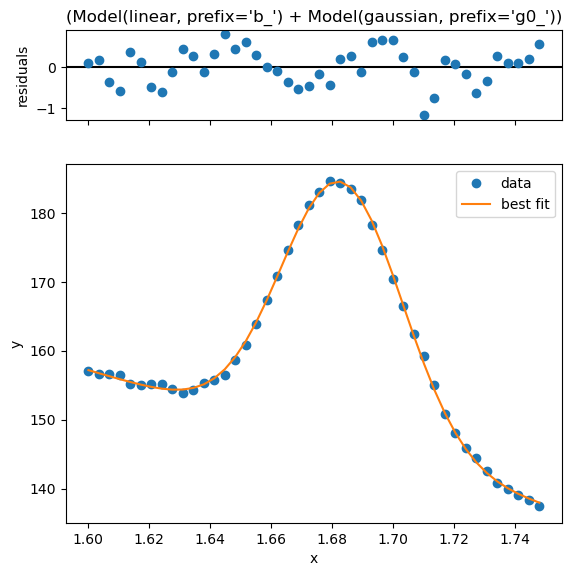

5
Figure(640x640)
chisqr is  5.062115800621722
x_motor and y motor are: (90.0,70.5)
peak centers:  [1.6838111856809777]


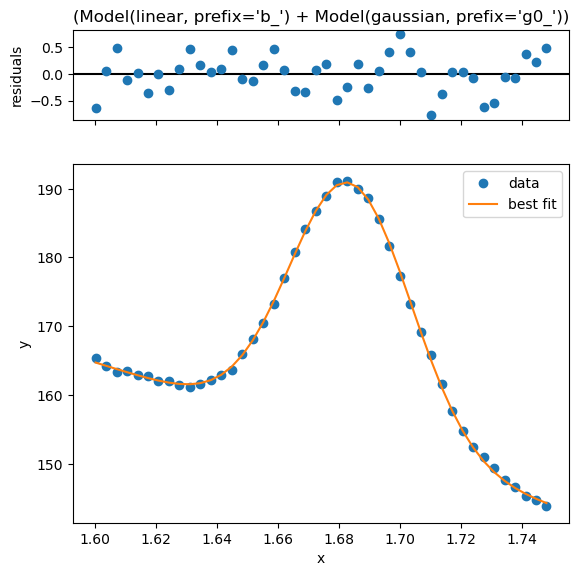

6
Figure(640x640)
chisqr is  7.58739722562574
x_motor and y motor are: (89.5,65.0)
peak centers:  [1.684087484150725]


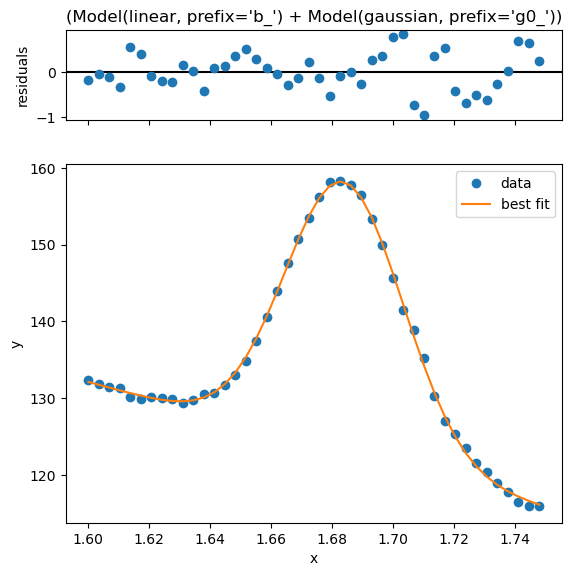

7
Figure(640x640)
chisqr is  7.855211086009559
x_motor and y motor are: (98.0,67.0)
peak centers:  [1.6842545455250248, 1.6925739560595292]


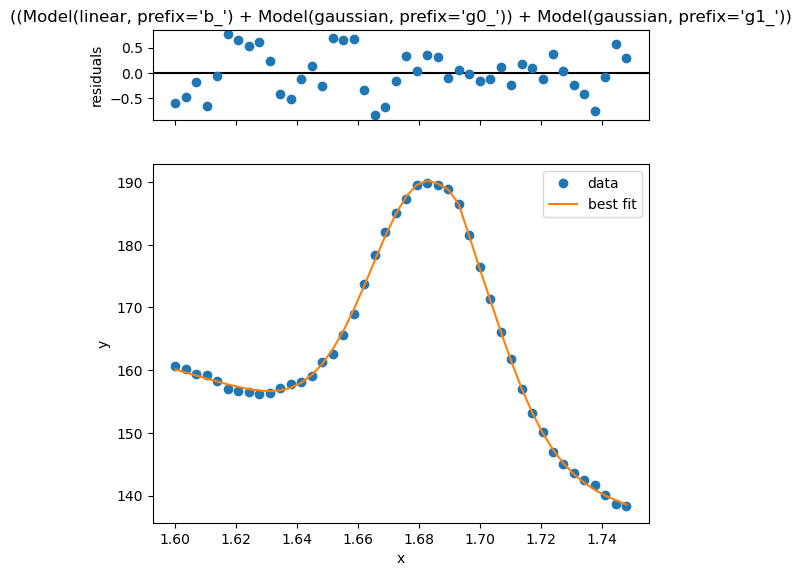

8
Figure(640x640)
chisqr is  6.140219228921935
x_motor and y motor are: (92.0,68.0)
peak centers:  [1.6838792169127308]


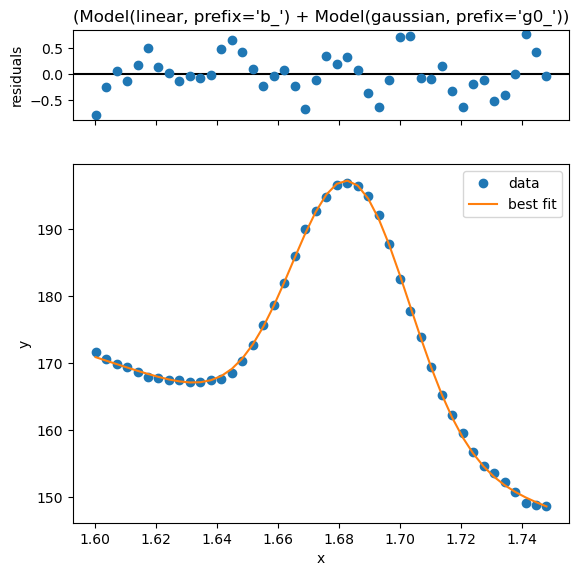

9
Figure(640x640)
chisqr is  4.37611963116934
x_motor and y motor are: (89.0,67.5)
peak centers:  [1.6876550519349647, 1.678878666227789]
THE THING HAPPENED MORE PEAKS


 fit not found
The chisqr is  10.81046086336502


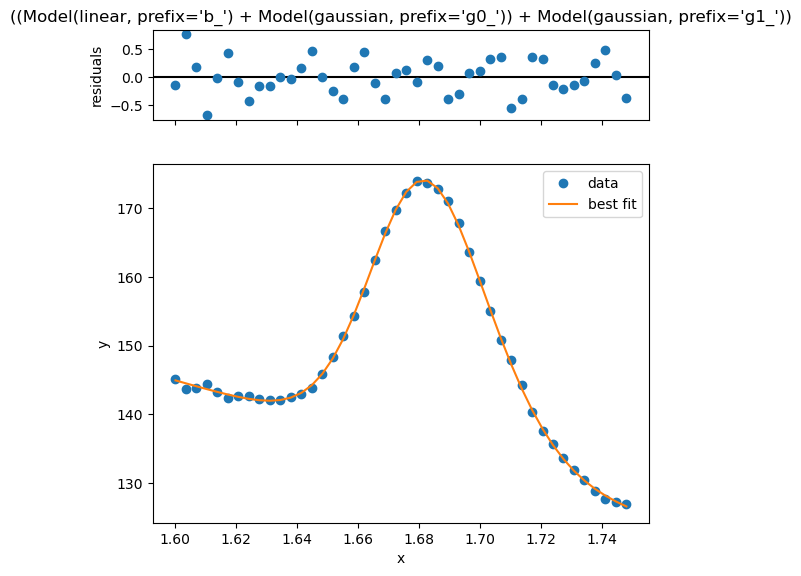

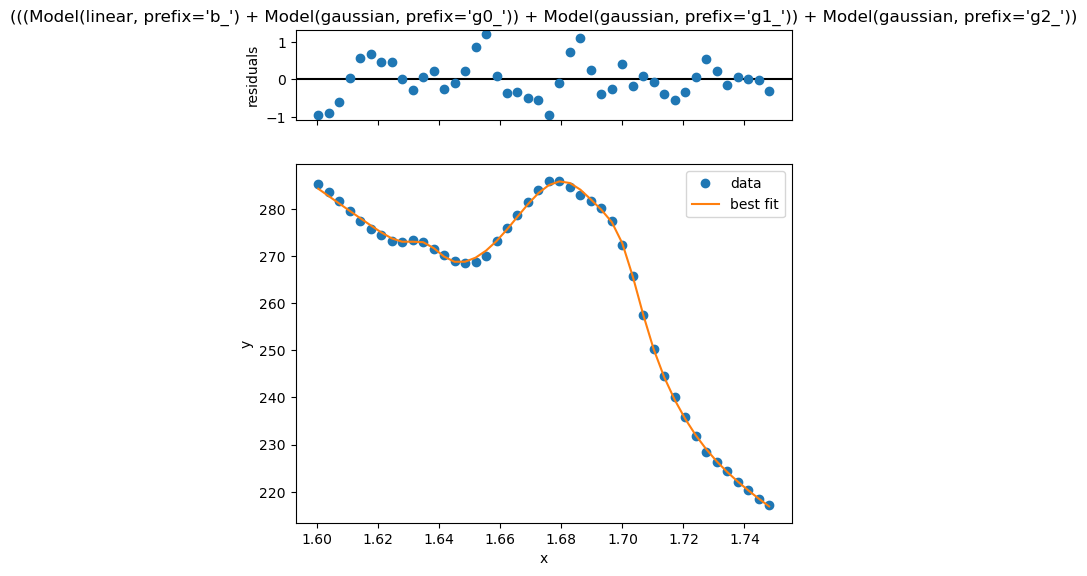

if its good enter y
y
chi squared: 10.81046086336502
10
Figure(640x640)
chisqr is  10.81046086336502
x_motor and y motor are: (88.5,64.5)
peak centers:  [1.6354947394864003, 1.6998385901501445, 1.6842684069134182]


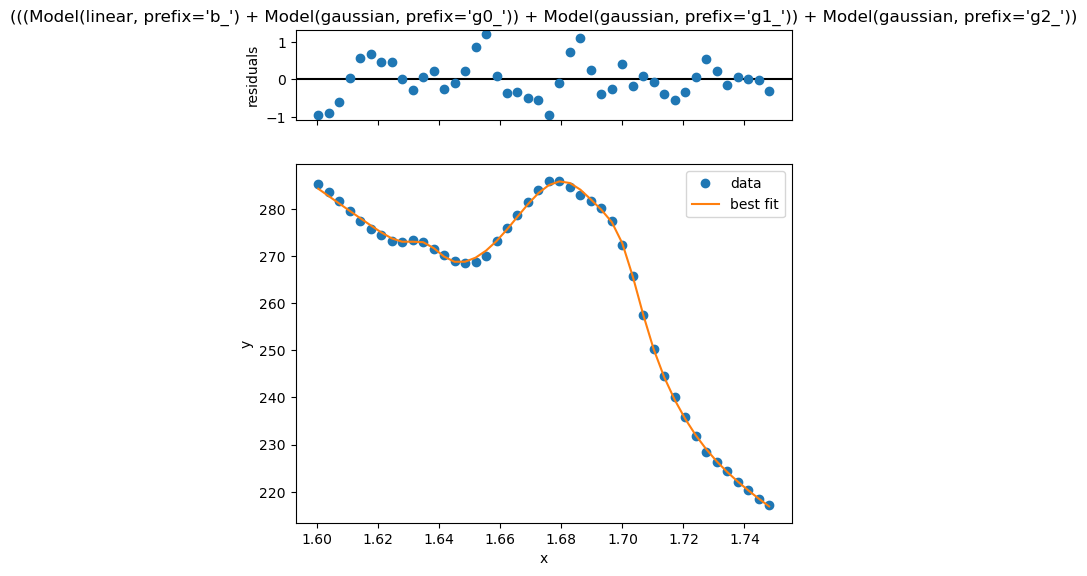

11
Figure(640x640)
chisqr is  6.76848587014843
x_motor and y motor are: (100.5,68.0)
peak centers:  [1.685765083191759, 1.6998741577708882]


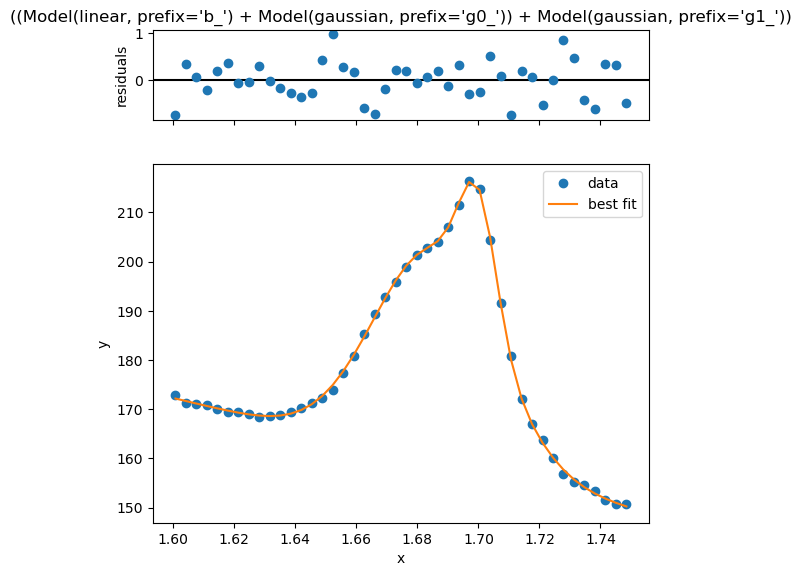

12
Figure(640x640)
chisqr is  8.656683742004793
x_motor and y motor are: (95.0,70.0)
peak centers:  [1.6835969228160992, 1.7380868117389074]


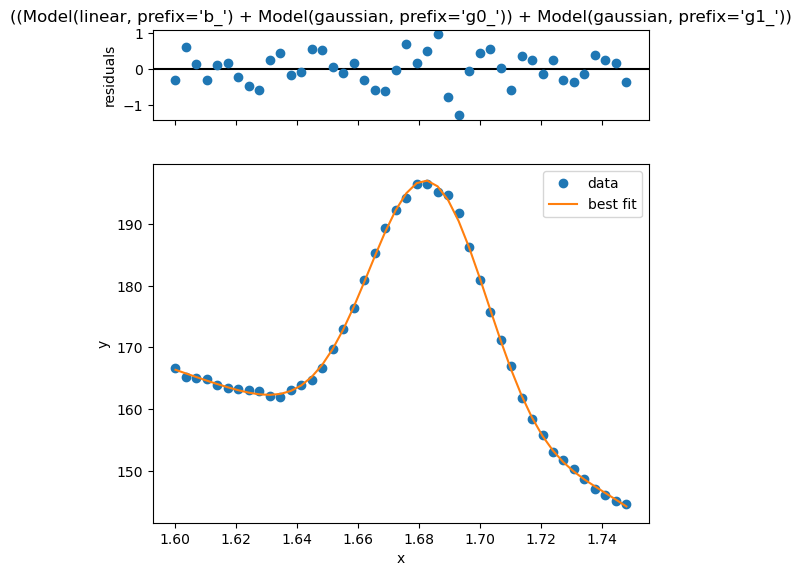

13
Figure(640x640)
chisqr is  8.843102601940402
x_motor and y motor are: (105.5,67.5)
peak centers:  [1.6832507075661662]


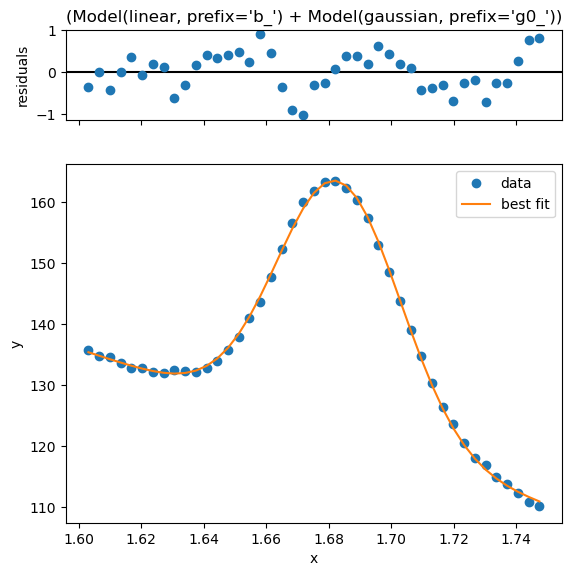

14
Figure(640x640)
chisqr is  8.463248006191902
x_motor and y motor are: (91.0,71.5)
peak centers:  [1.684344861397217]


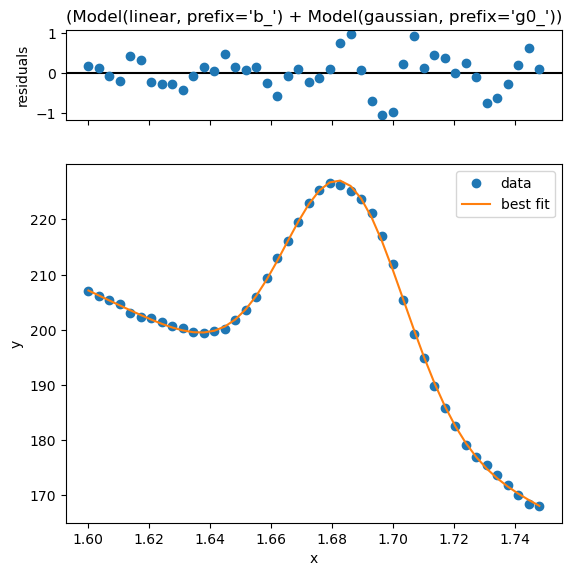

15
Figure(640x640)
chisqr is  7.892509360911177
x_motor and y motor are: (99.0,70.5)
peak centers:  [1.6835845228108663]


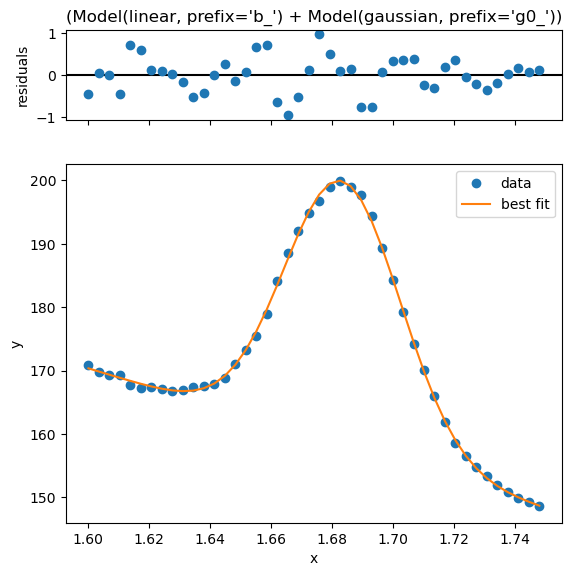

16
Figure(640x640)
chisqr is  3.6170286597769374
x_motor and y motor are: (105.0,67.0)
peak centers:  [1.6892189850898016, 1.6825622599870709]


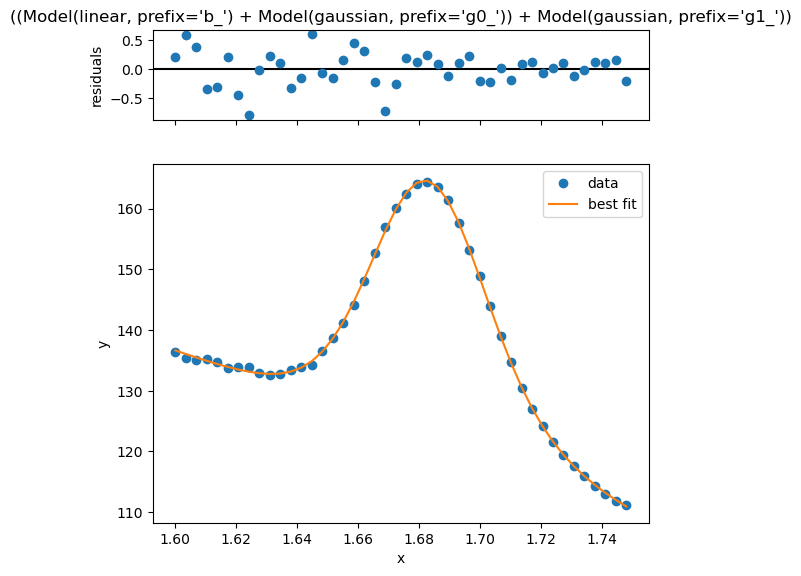

17
Figure(640x640)
chisqr is  9.874265963341461
x_motor and y motor are: (105.0,66.5)
peak centers:  [1.6840276472996012]


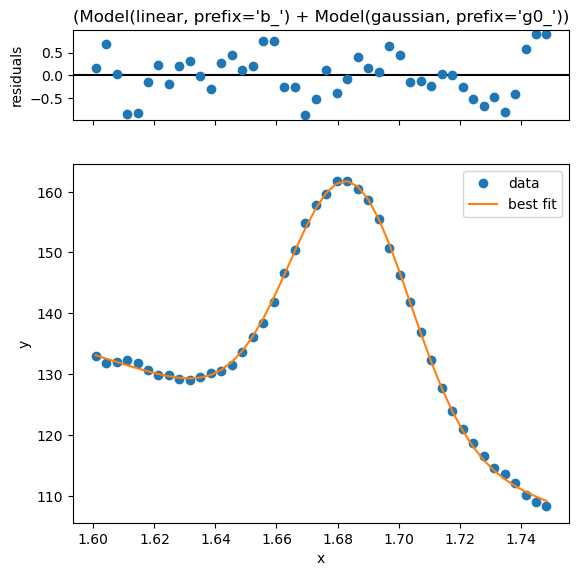

18
Figure(640x640)
chisqr is  7.259968301117808
x_motor and y motor are: (93.5,68.5)
peak centers:  [1.6840701049321036]


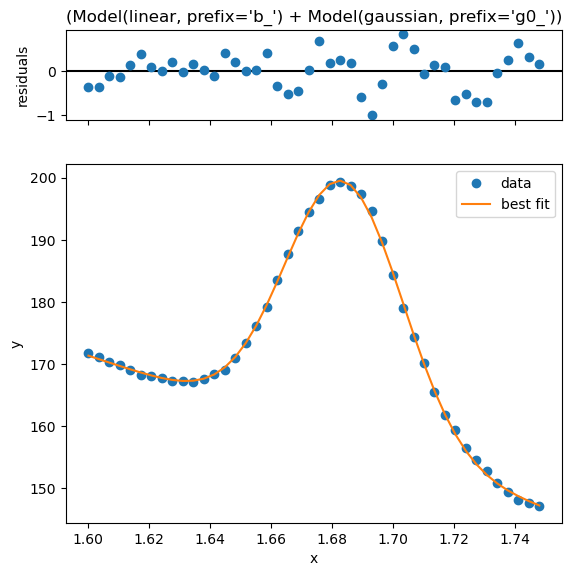

19
Figure(640x640)
chisqr is  7.238467748241358
x_motor and y motor are: (101.0,65.5)
peak centers:  [1.6713159430810234, 1.6852196530018628, 1.690102098220986]
THE THING HAPPENED MORE PEAKS


 fit not found
The chisqr is  27.64563478721247


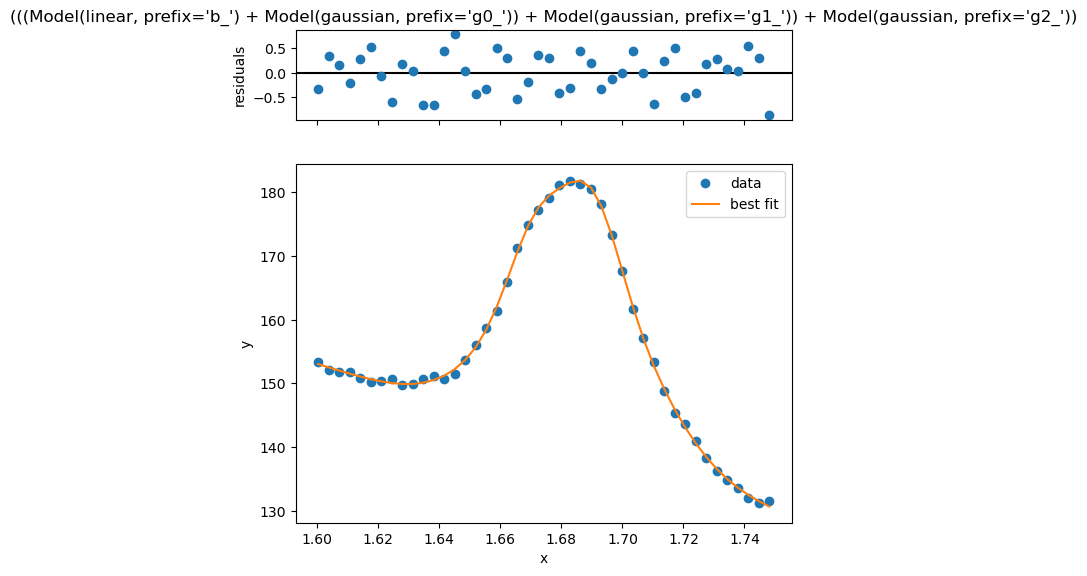

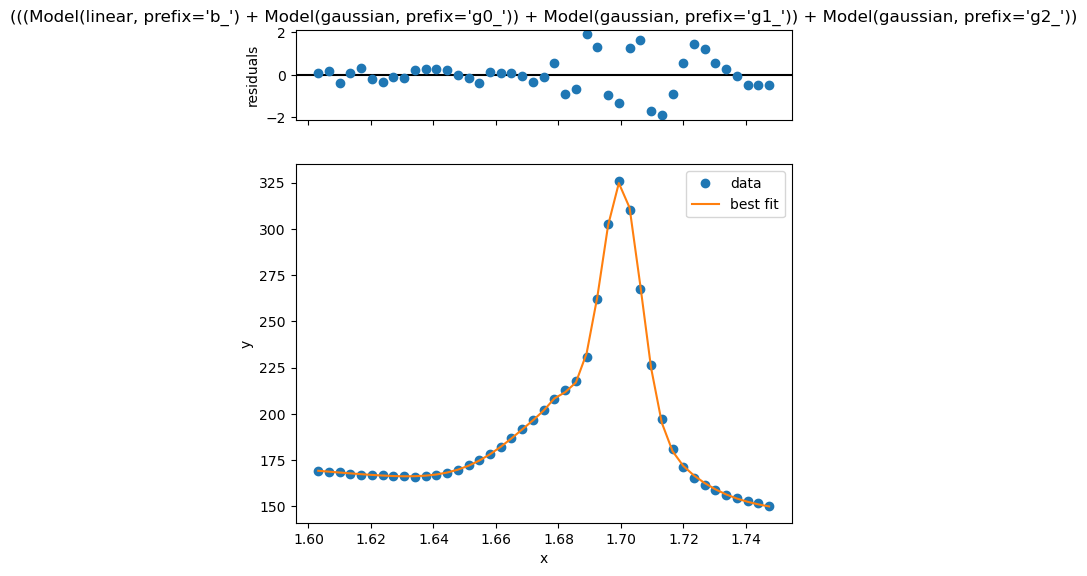

if its good enter y
y
chi squared: 27.64563478721247
20
Figure(640x640)
chisqr is  27.64563478721247
x_motor and y motor are: (102.0,66.5)
peak centers:  [1.7002435091804506, 1.6797136039071465, 1.689723260944354]


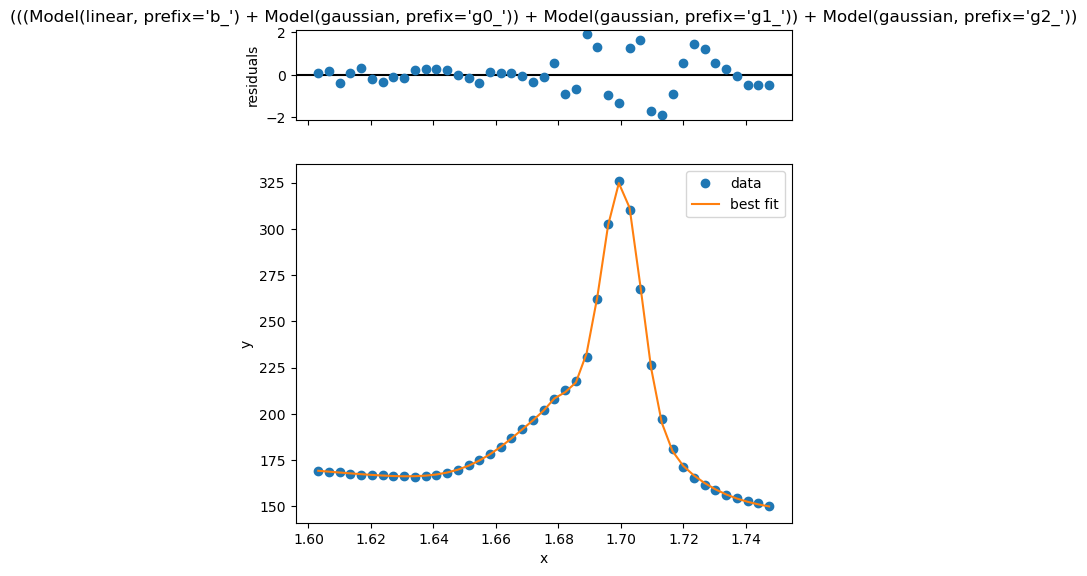

21
Figure(640x640)
chisqr is  8.981668199016893
x_motor and y motor are: (100.5,64.5)
peak centers:  [1.6831027041363733]


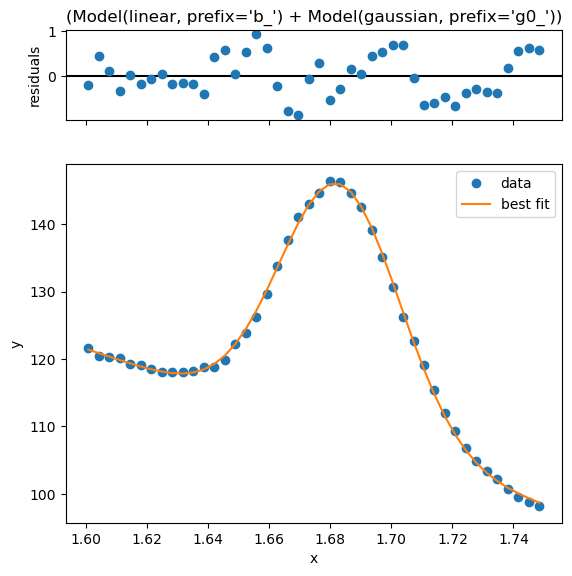

22
Figure(640x640)
chisqr is  5.459234883908195
x_motor and y motor are: (99.5,67.0)
peak centers:  [1.6856435683739566, 1.6768462709360445, 1.6955099528009987]


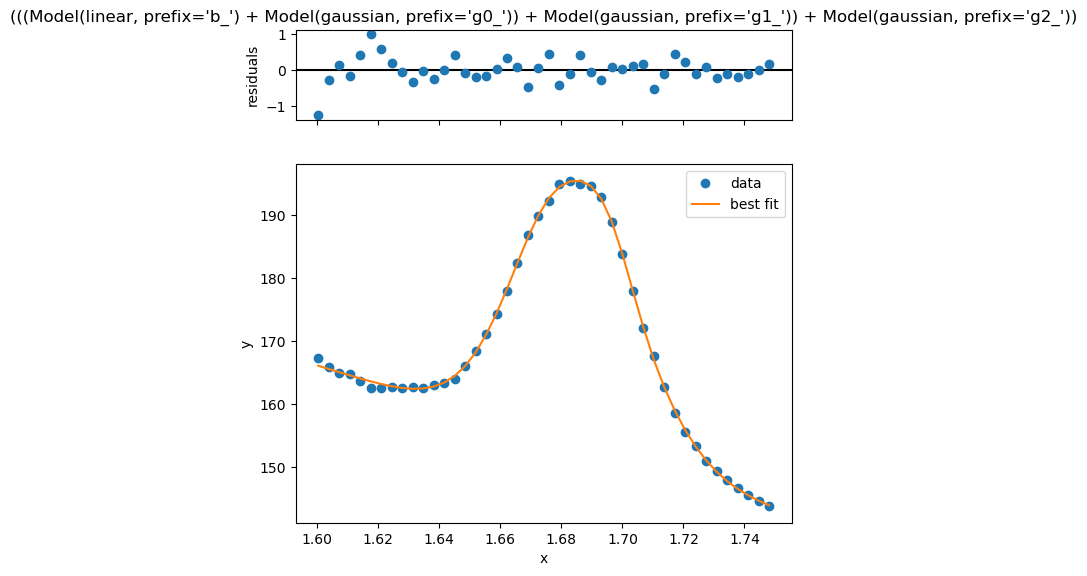

23
Figure(640x640)
chisqr is  6.429264960773757
x_motor and y motor are: (97.0,66.5)
peak centers:  [1.7273847309570698, 1.6844840273761674]


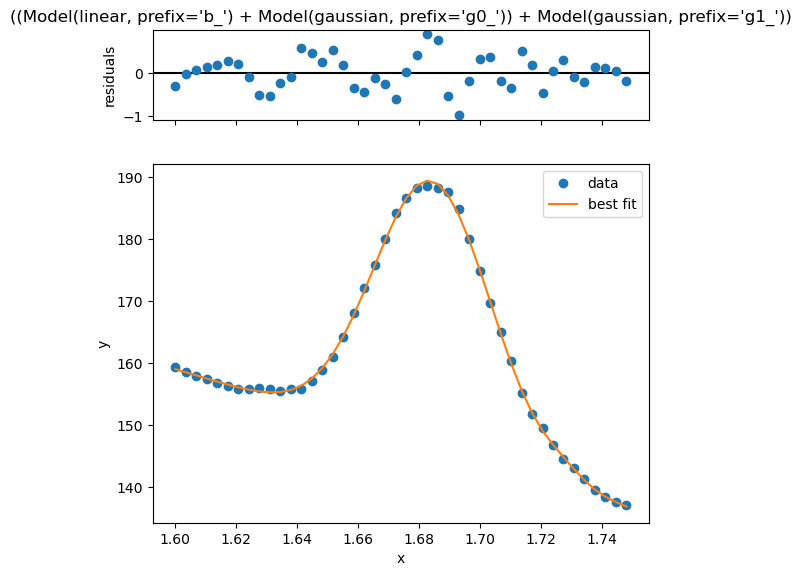

24
Figure(640x640)
chisqr is  8.809405587854613
x_motor and y motor are: (101.5,68.5)
peak centers:  [1.6859647863045633, 1.7003124623599184]


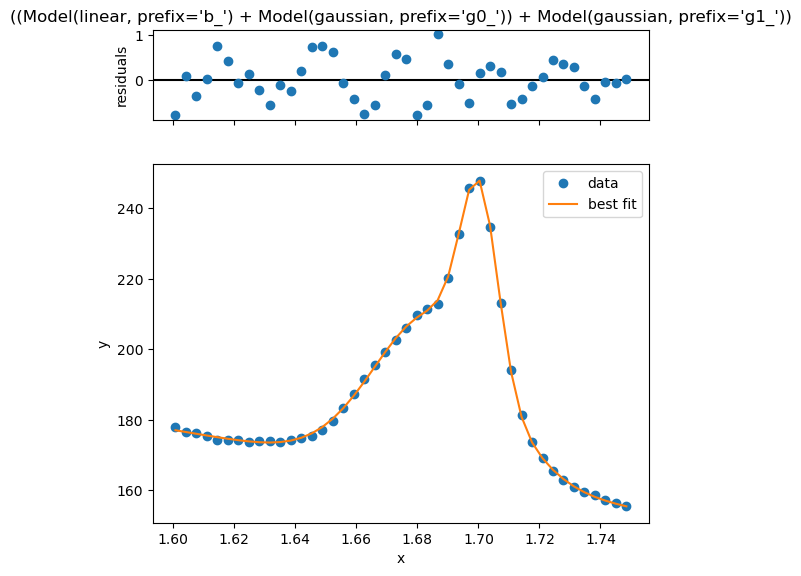

25
Figure(640x640)
chisqr is  9.418536069921528
x_motor and y motor are: (94.5,70.0)
peak centers:  [1.683301369440042, 1.7183663788124928]


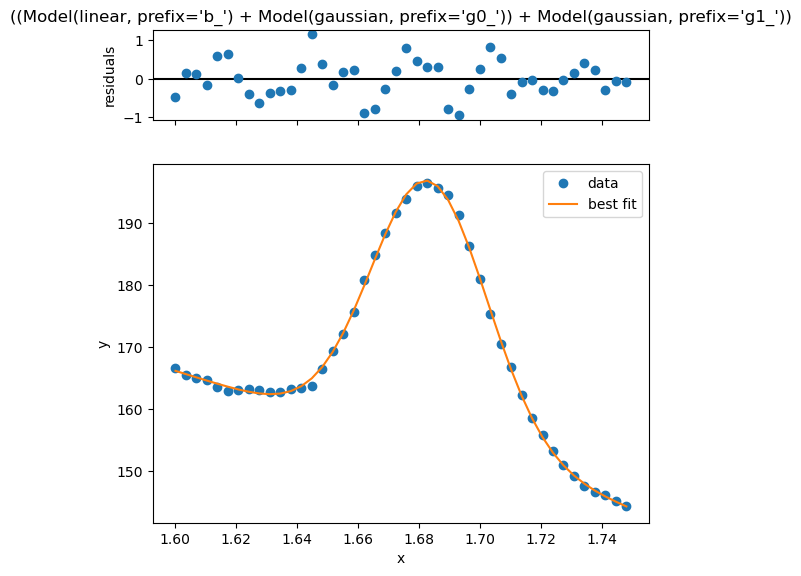

26
Figure(640x640)
chisqr is  8.57182430718438
x_motor and y motor are: (98.0,69.5)
peak centers:  [1.600778020926603, 1.6840611598805324]


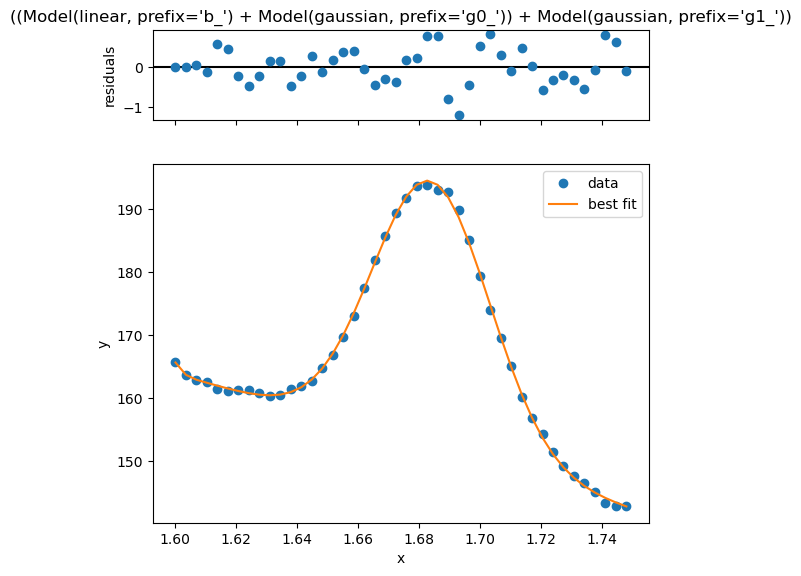

27
Figure(640x640)
chisqr is  6.688377771860626
x_motor and y motor are: (97.0,70.5)
peak centers:  [1.6838675077828593]


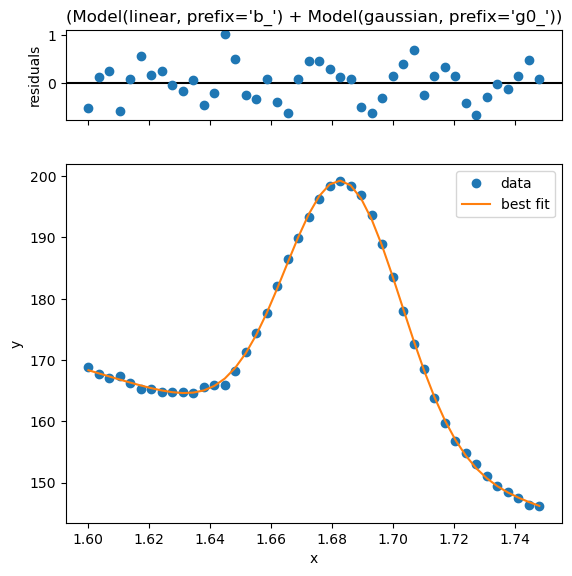

28
Figure(640x640)
chisqr is  6.814022304962782
x_motor and y motor are: (103.5,65.5)
peak centers:  [1.6835395941537448]


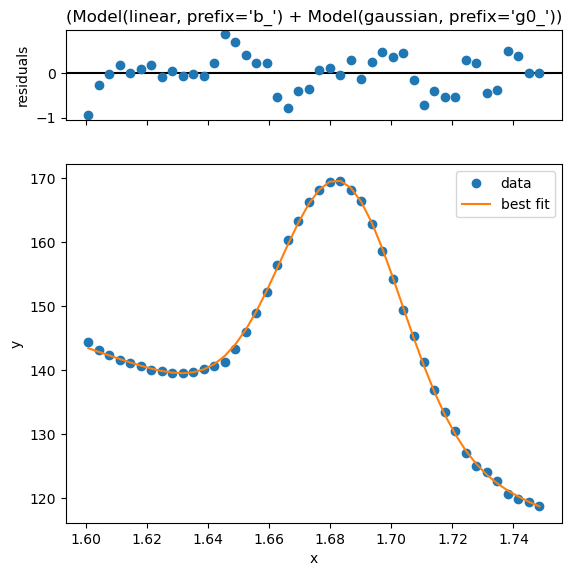

29
Figure(640x640)
chisqr is  5.633032686288187
x_motor and y motor are: (89.0,67.0)
peak centers:  [1.6873158384772204, 1.6779061828788286]


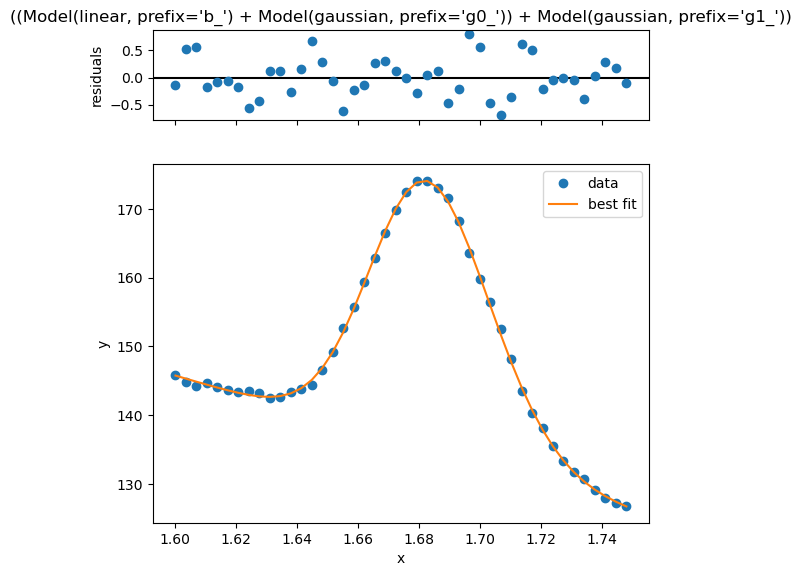

30
Figure(640x640)
chisqr is  5.812570190397001
x_motor and y motor are: (104.0,70.5)
peak centers:  [1.6850056458767493, 1.678641244935798]


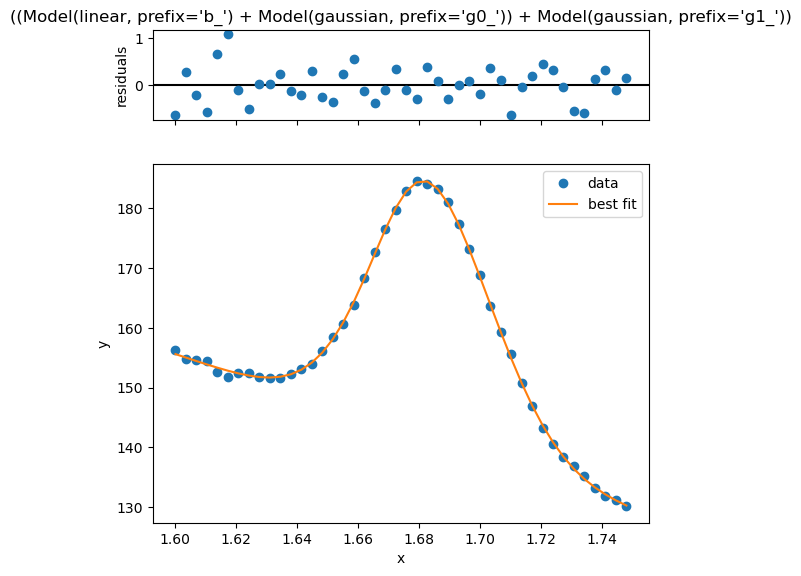

31
Figure(640x640)
chisqr is  8.730675696741413
x_motor and y motor are: (95.5,70.5)
peak centers:  [1.683983104116678]


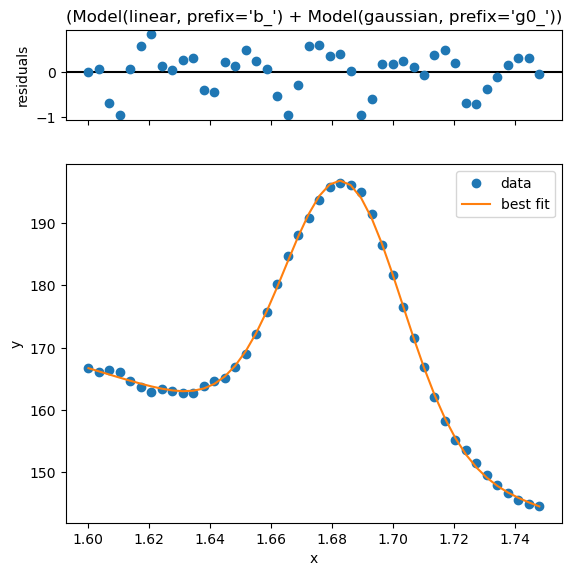

32
Figure(640x640)
chisqr is  8.867068429774111
x_motor and y motor are: (89.5,68.0)
peak centers:  [1.6836999979495506]


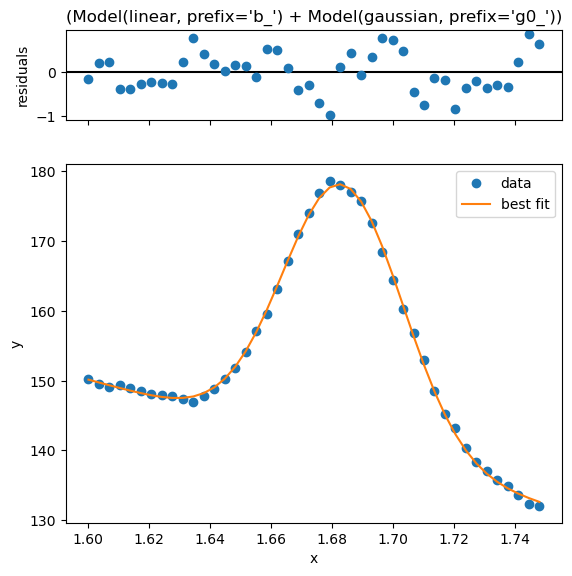

33
Figure(640x640)
chisqr is  6.116472669015926
x_motor and y motor are: (95.5,68.0)
peak centers:  [1.7041198496007965, 1.6917616403098037, 1.6797502668902684]


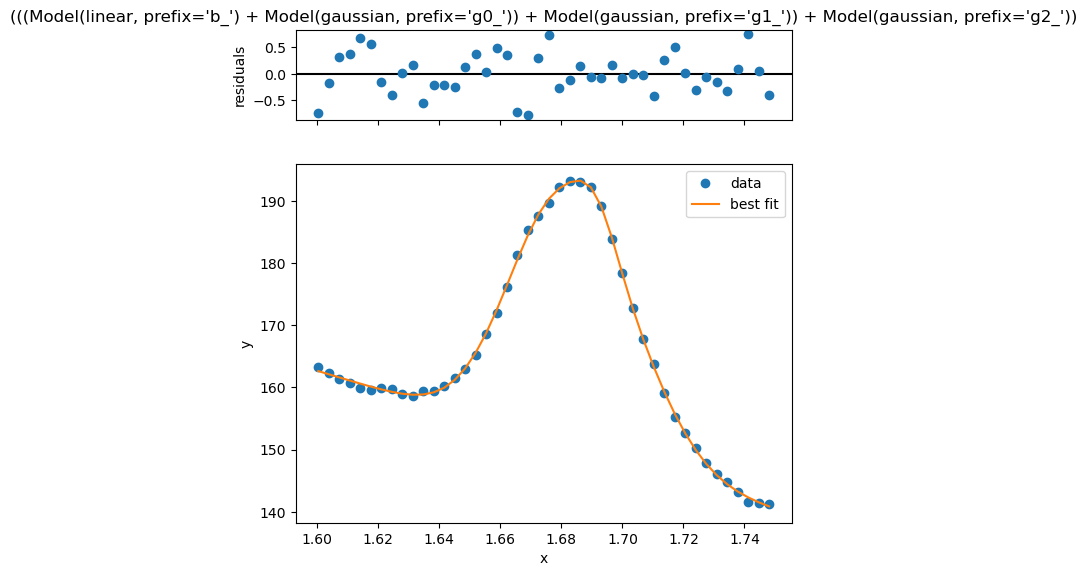

34
Figure(640x640)
chisqr is  7.3750864653649035
x_motor and y motor are: (94.0,68.0)
peak centers:  [1.6839230735995356]


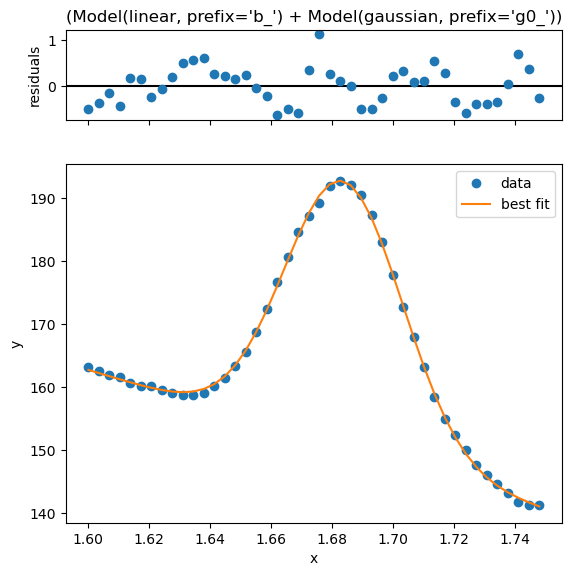

35
Figure(640x640)
chisqr is  5.877150646078211
x_motor and y motor are: (98.5,66.5)
peak centers:  [1.68463164387815]


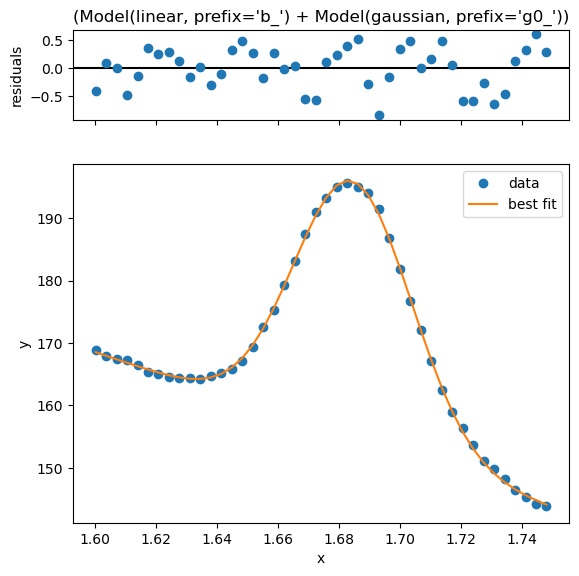

36
Figure(640x640)
chisqr is  4.879455464259904
x_motor and y motor are: (89.0,64.5)
peak centers:  [1.6355813384797, 1.6844853620721476, 1.7001576979956488]


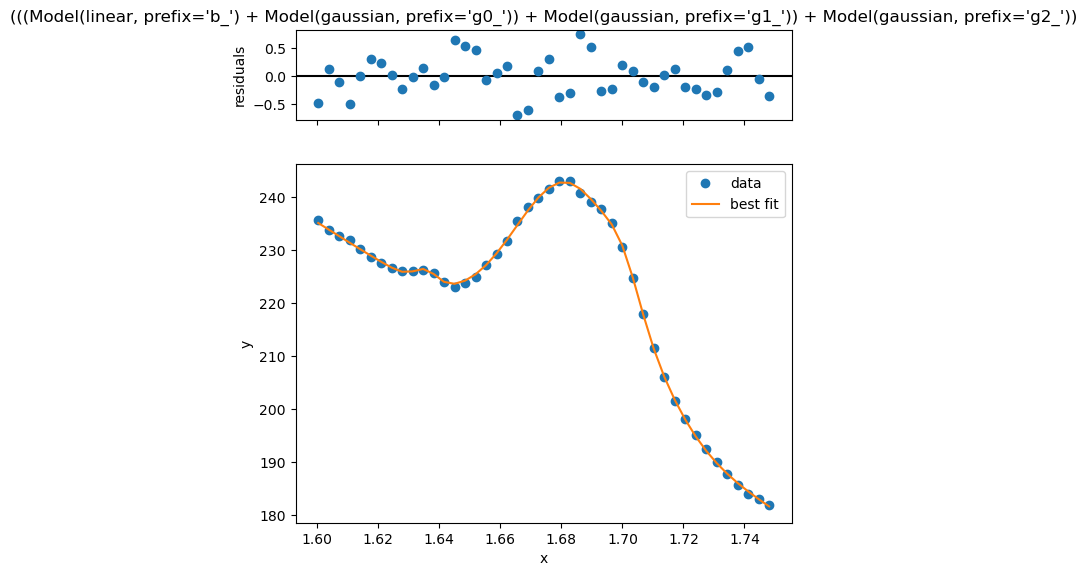

37
Figure(640x640)
chisqr is  9.083312845819128
x_motor and y motor are: (97.5,70.0)
peak centers:  [1.6839473777607261]


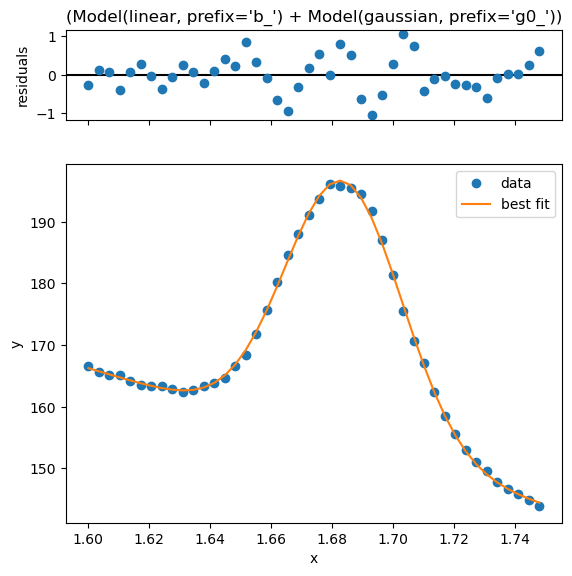

38
Figure(640x640)
chisqr is  8.426257648857616
x_motor and y motor are: (92.5,67.5)
peak centers:  [1.6839942631912106, 1.6927739068227279]


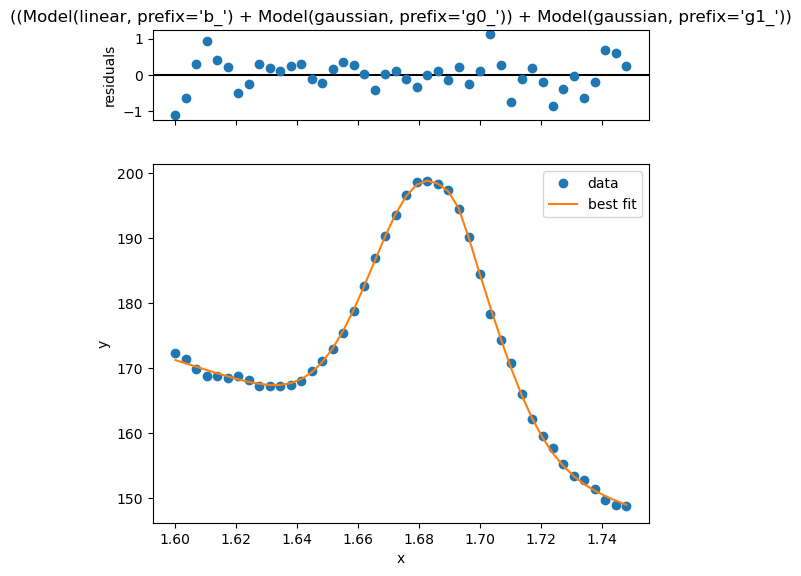

39
Figure(640x640)
chisqr is  6.341573519482723
x_motor and y motor are: (98.5,69.0)
peak centers:  [1.6841337222715413]


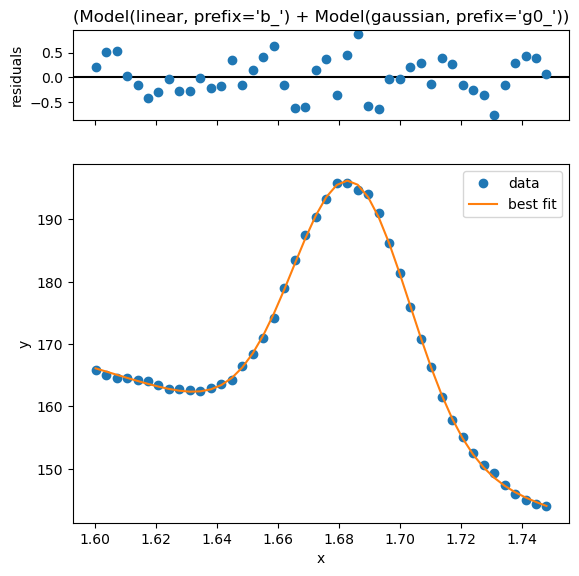

40
Figure(640x640)
chisqr is  8.047910463262435
x_motor and y motor are: (90.5,69.5)
peak centers:  [1.6836673645520908]


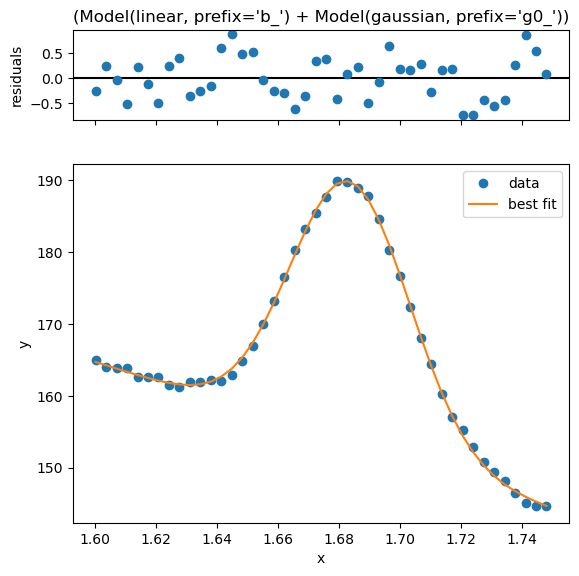

41
Figure(640x640)
chisqr is  8.877746872662925
x_motor and y motor are: (98.5,64.5)
peak centers:  [1.683841239887169]


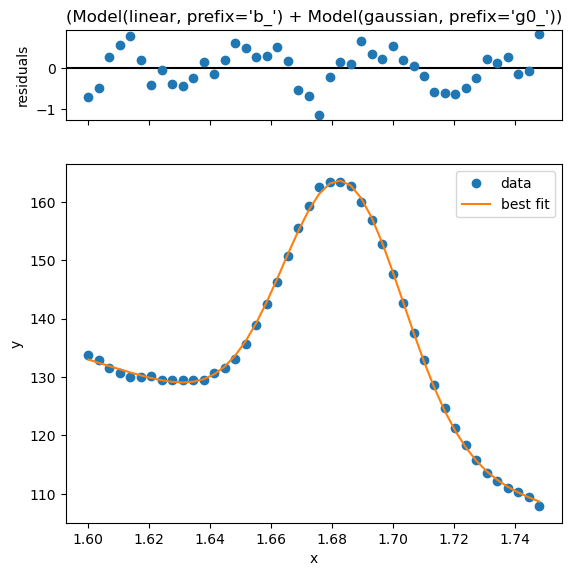

42
Figure(640x640)
chisqr is  4.922151081614974
x_motor and y motor are: (88.5,68.0)
peak centers:  [1.687222609871224, 1.6772318725667723]


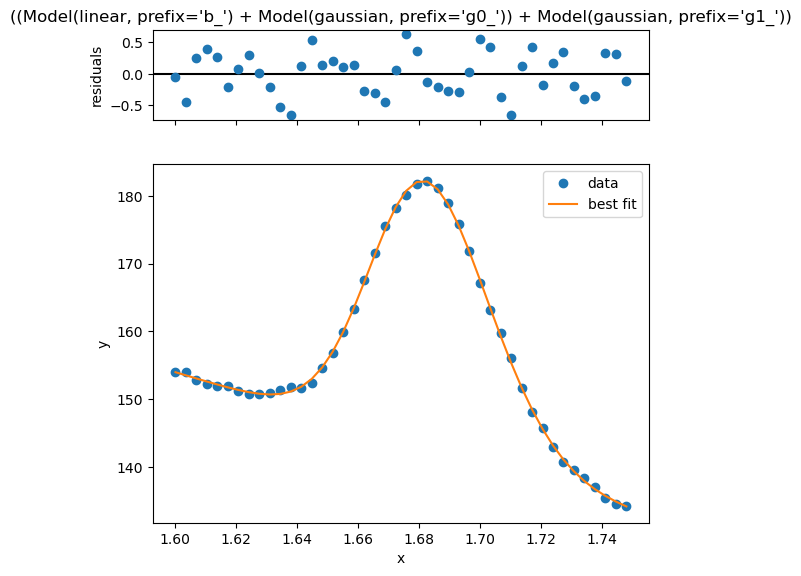

43
Figure(640x640)
chisqr is  7.611205331407272
x_motor and y motor are: (97.0,66.0)
peak centers:  [1.6845026738488522]


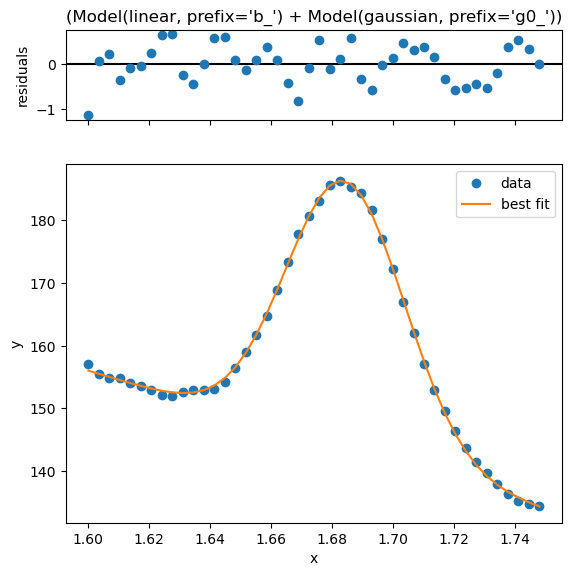

44
Figure(640x640)
chisqr is  7.625376253768373
x_motor and y motor are: (94.5,65.5)
peak centers:  [1.6837689732184777]


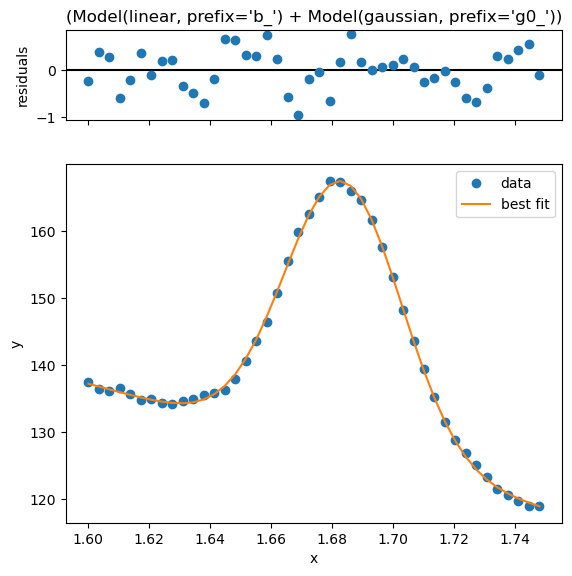

45
Figure(640x640)
chisqr is  6.022941107449649
x_motor and y motor are: (91.0,68.5)
peak centers:  [1.674178828896127, 1.6898540554685069]


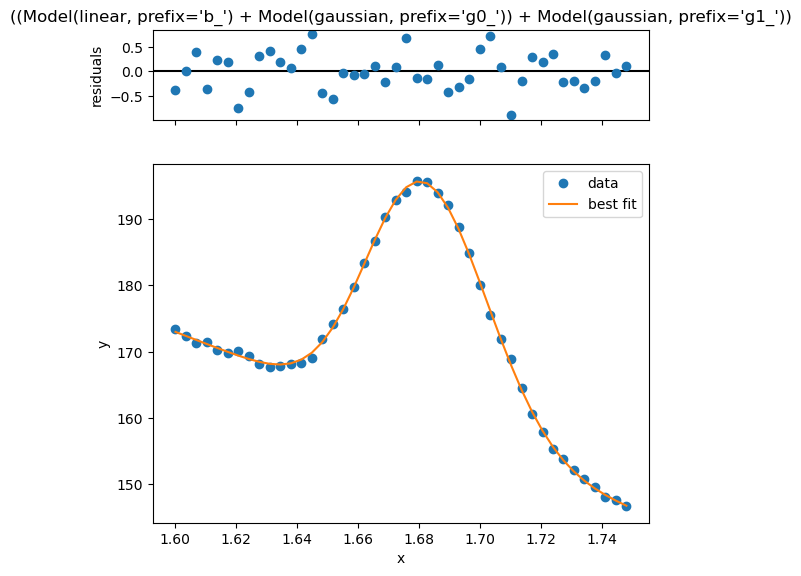

46
Figure(640x640)
chisqr is  9.83559293734452
x_motor and y motor are: (94.0,68.5)
peak centers:  [1.6838819958638738]


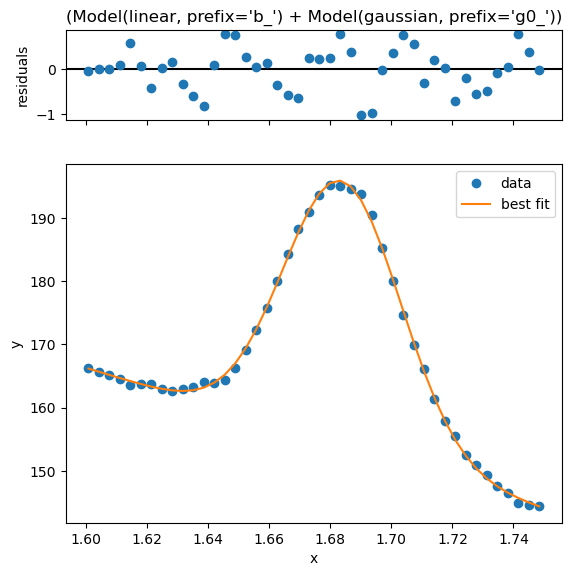

47
Figure(640x640)
chisqr is  9.990450031100886
x_motor and y motor are: (92.0,64.5)
peak centers:  [1.6832121245146923]


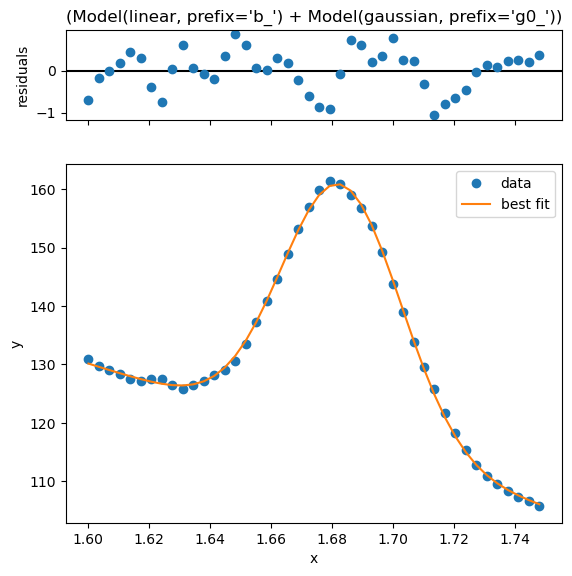

48
Figure(640x640)
chisqr is  4.72214221771477
x_motor and y motor are: (101.0,67.0)
peak centers:  [1.6860283130265565, 1.6998743060156578]


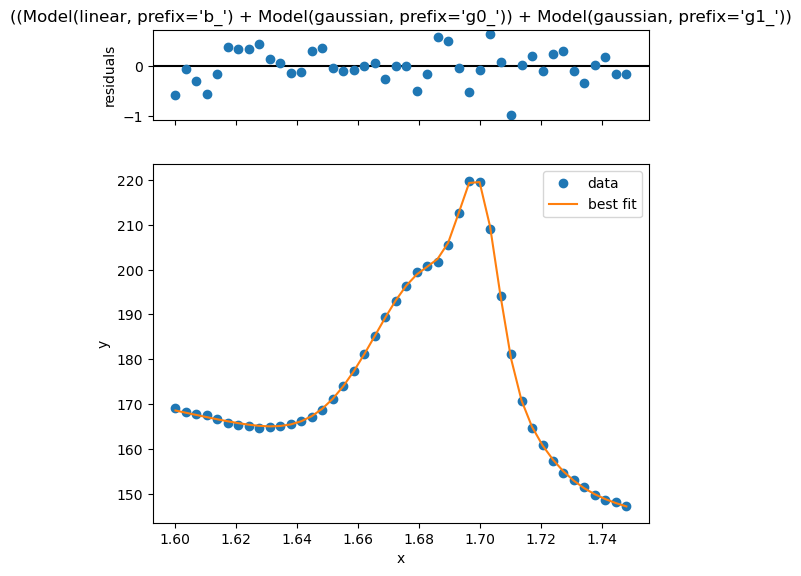

49
Figure(640x640)
chisqr is  4.938733625291235
x_motor and y motor are: (91.0,67.5)
peak centers:  [1.6815294228461652, 1.7139026518414542]


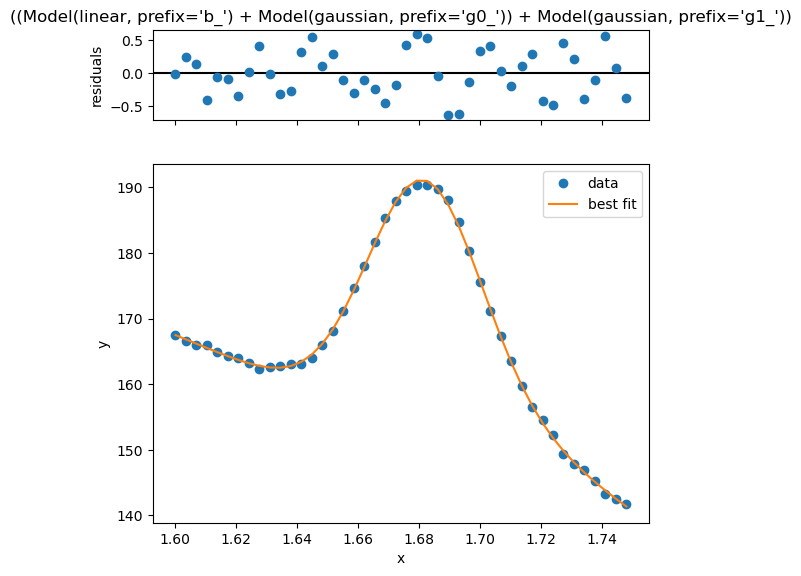

50
Figure(640x640)
chisqr is  9.554055655918146
x_motor and y motor are: (93.0,66.5)
peak centers:  [1.6839154432544858]


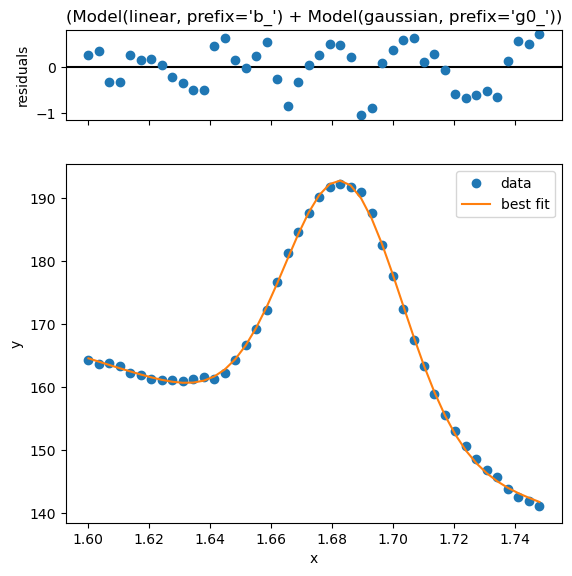

51
Figure(640x640)
chisqr is  6.859064869889828
x_motor and y motor are: (102.5,71.5)
peak centers:  [1.6358285650919175, 1.698754094246963, 1.6841909205536347]


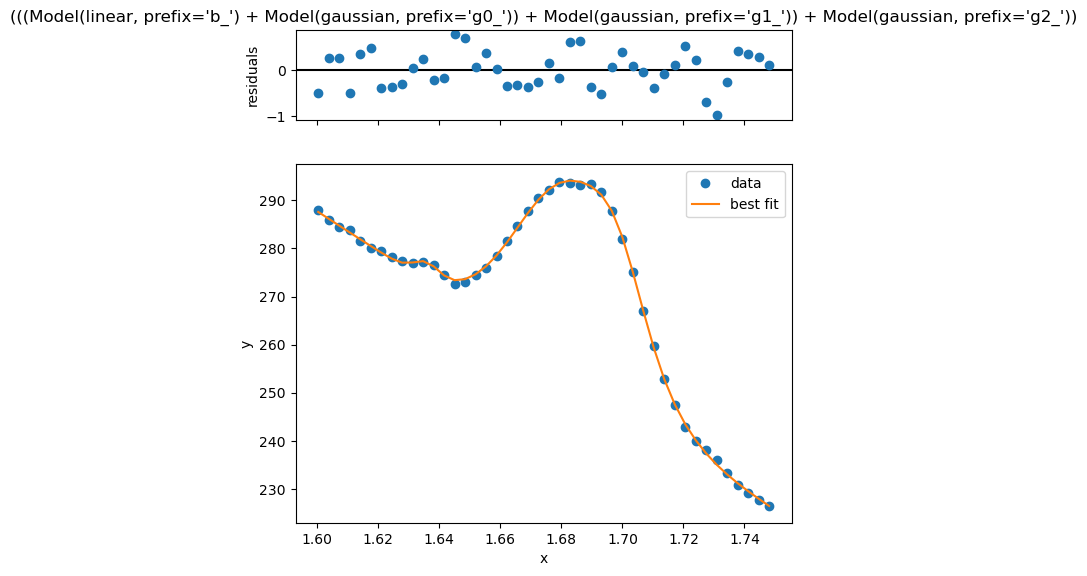

52
Figure(640x640)
chisqr is  9.087407088712572
x_motor and y motor are: (90.0,65.5)
peak centers:  [1.684156539799191]
THE THING HAPPENED MORE PEAKS


 fit not found
The chisqr is  11.390813611308737


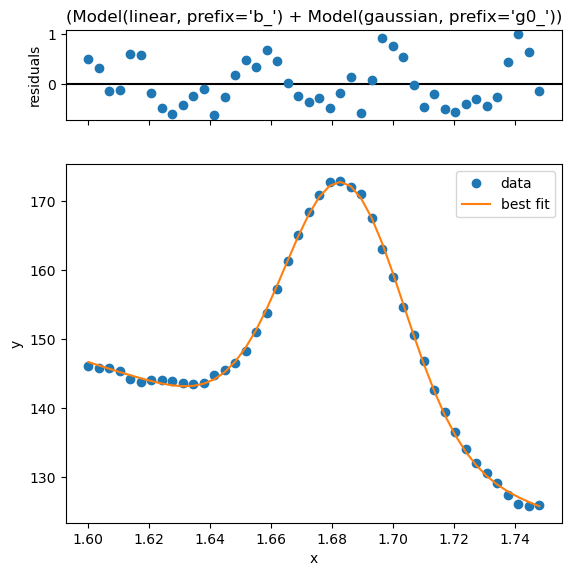

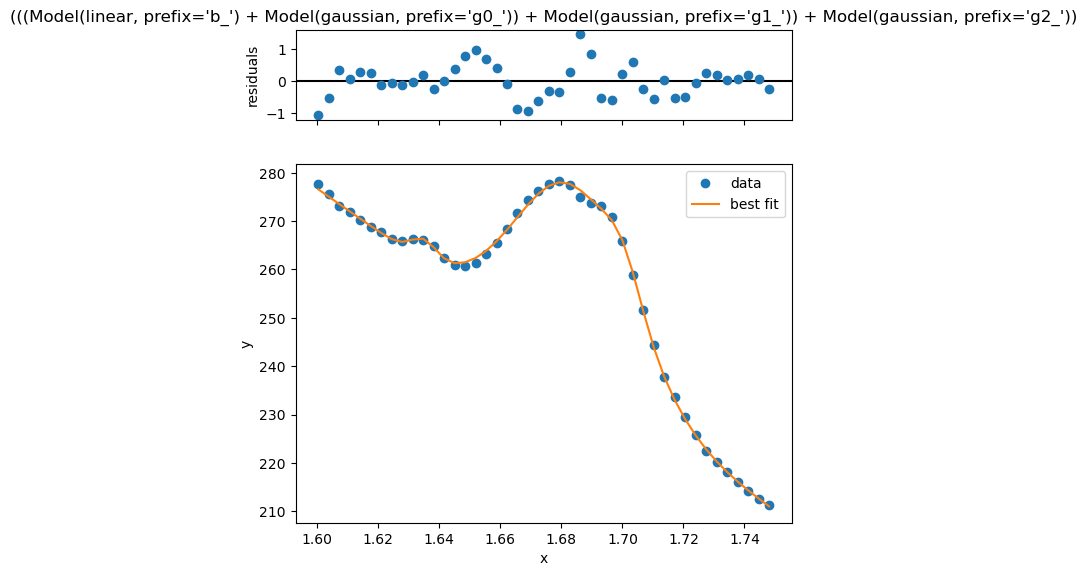

if its good enter y
y
chi squared: 11.390813611308737
53
Figure(640x640)
chisqr is  11.390813611308737
x_motor and y motor are: (88.5,64.5)
peak centers:  [1.63493000605312, 1.6842083972545607, 1.7002143203600626]


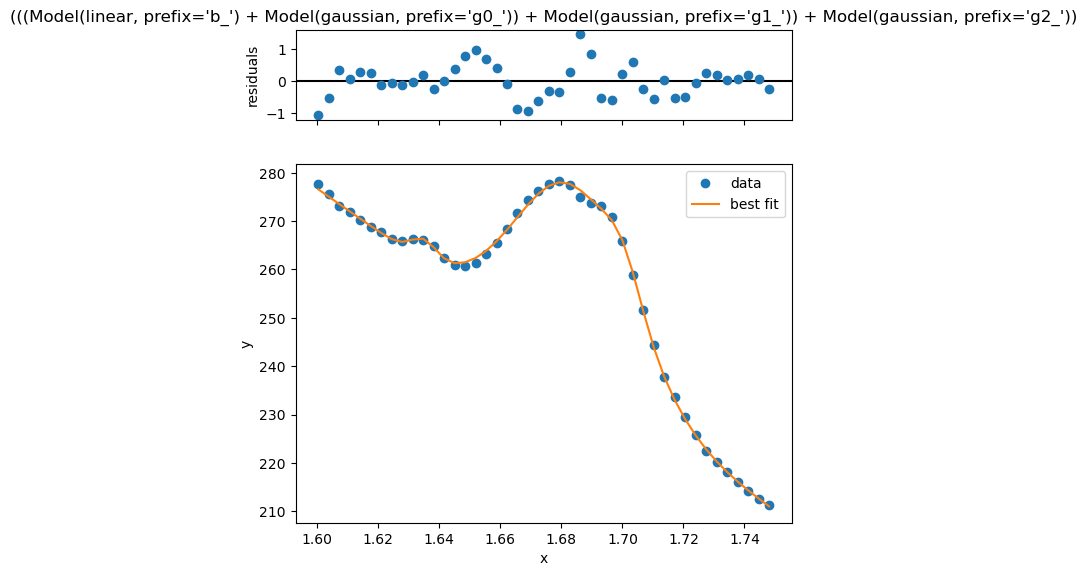

54
Figure(640x640)
chisqr is  6.145999103814178
x_motor and y motor are: (104.0,66.5)
peak centers:  [1.7031713310309806, 1.681932356086297]
THE THING HAPPENED MORE PEAKS


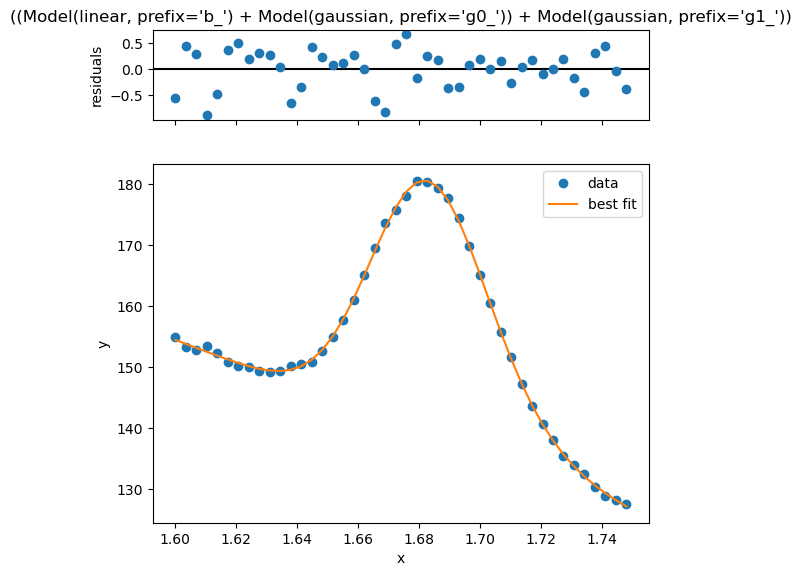

55
Figure(640x640)
chisqr is  7.4253154427620665
x_motor and y motor are: (103.0,71.5)
peak centers:  [1.6358685152675556, 1.683965273633333, 1.6994397453077488]


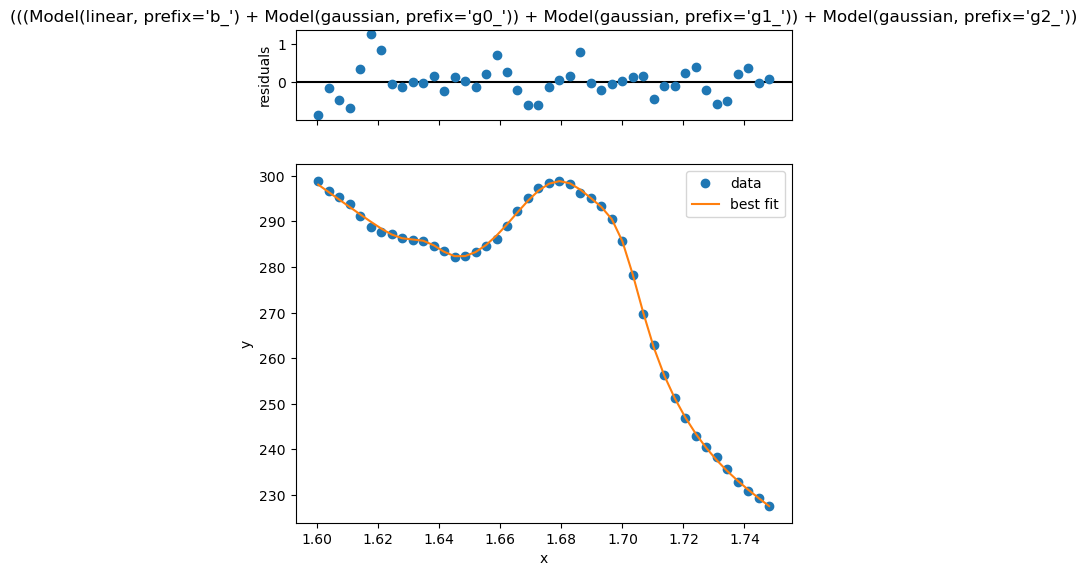

56
Figure(640x640)
chisqr is  8.022994031591374
x_motor and y motor are: (97.5,66.5)
peak centers:  [1.6844831899326749]


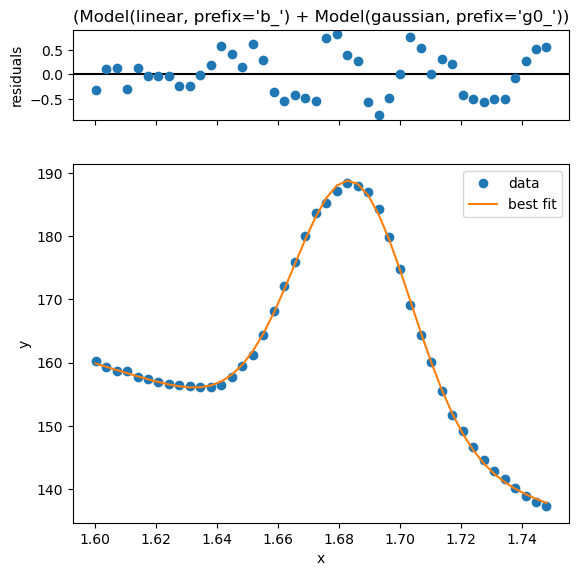

57
Figure(640x640)
chisqr is  5.270929700320279
x_motor and y motor are: (90.5,67.0)
peak centers:  [1.6861167020985253, 1.679383872307421]


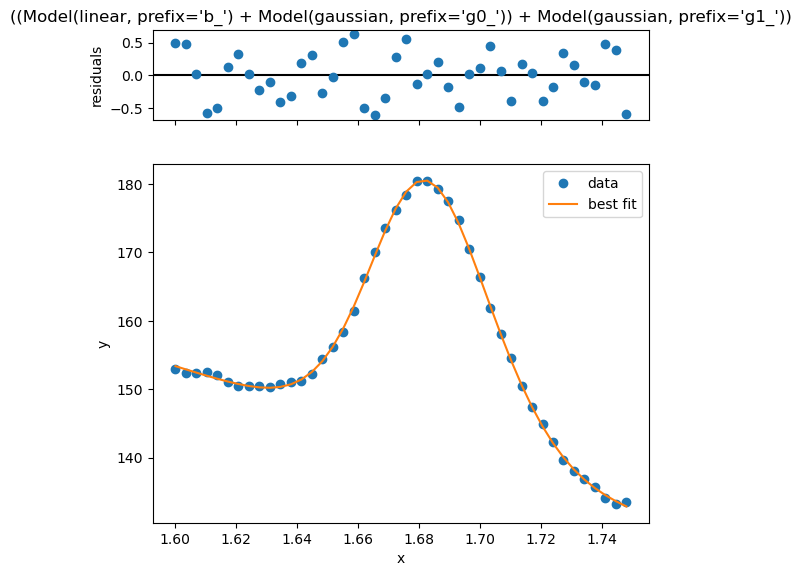

58
Figure(640x640)
chisqr is  7.387275472317829
x_motor and y motor are: (93.0,67.0)
peak centers:  [1.6844465089594565, 1.7316857510774715]


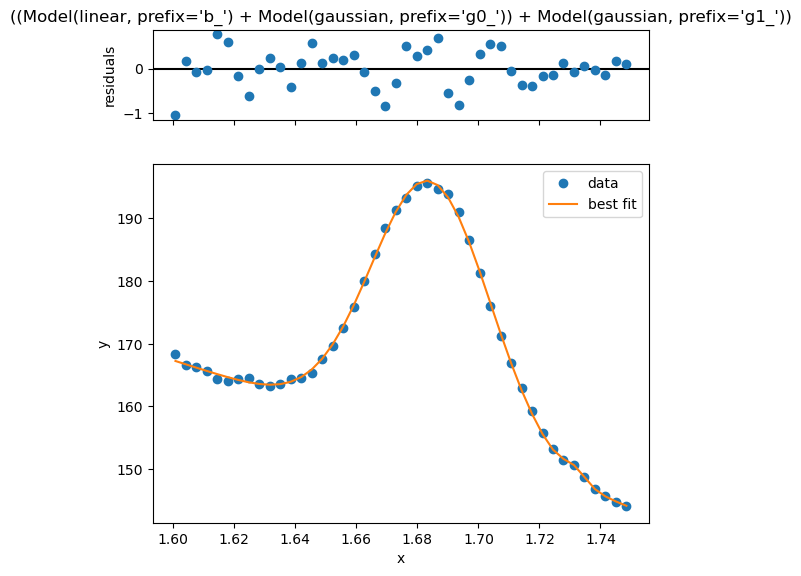

59
Figure(640x640)
chisqr is  9.100018328148641
x_motor and y motor are: (89.0,68.0)
peak centers:  [1.683755823475651]


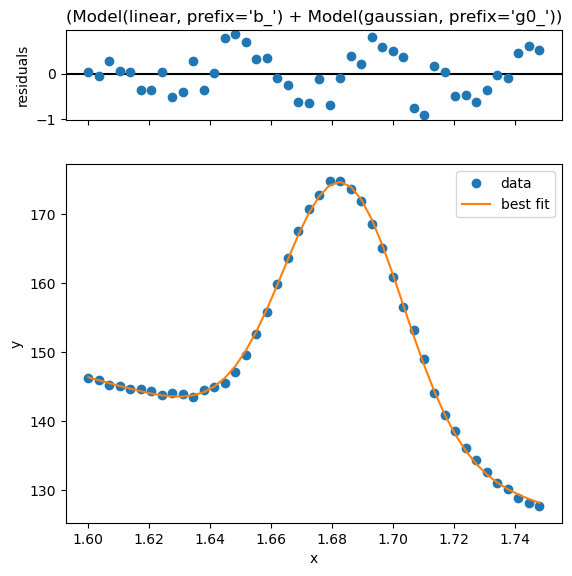

60
Figure(640x640)
chisqr is  9.370386075686573
x_motor and y motor are: (90.5,68.5)
peak centers:  [1.6837509548550404]


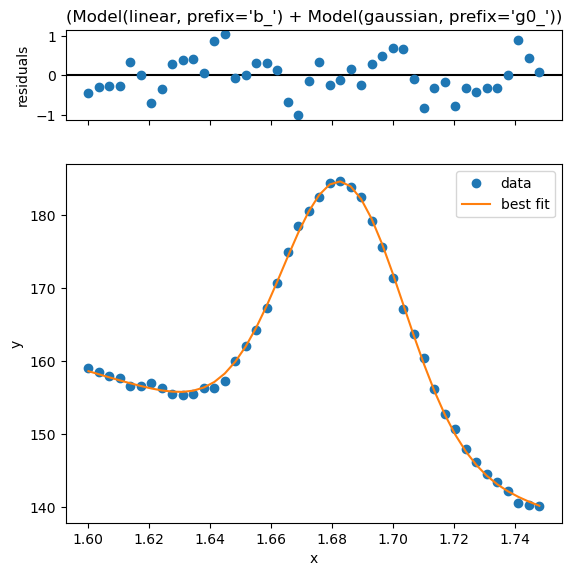

61
Figure(640x640)
chisqr is  5.232467892830246
x_motor and y motor are: (100.5,67.0)
peak centers:  [1.6854389383779917, 1.6996436952067753]


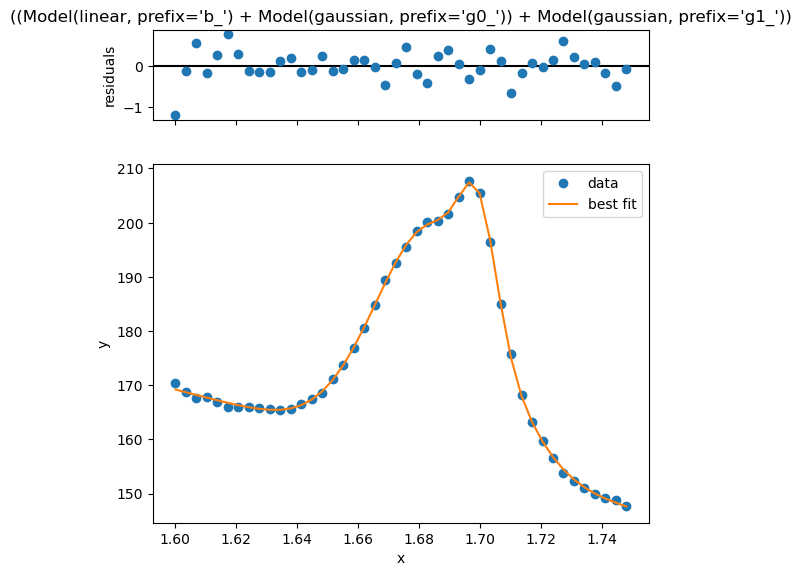

62
Figure(640x640)
chisqr is  5.961257947518959
x_motor and y motor are: (104.5,66.0)
peak centers:  [1.6863124691697342, 1.6809596654924763]


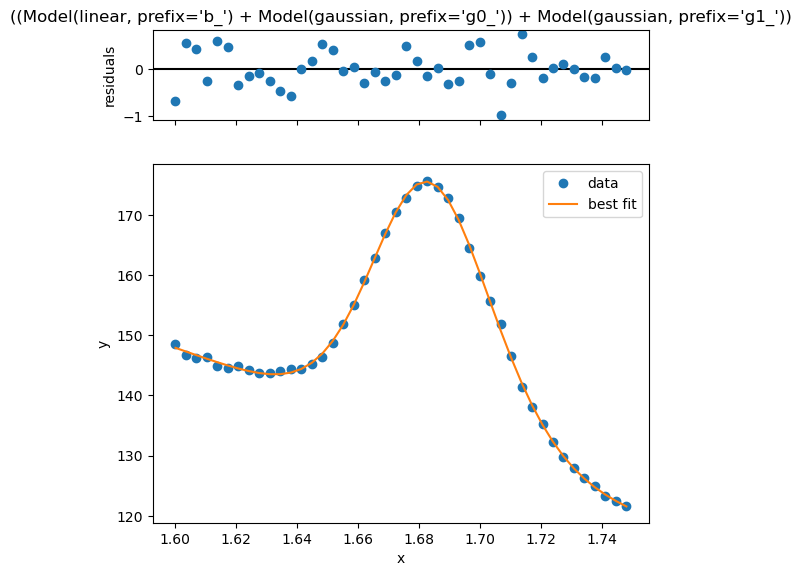

63
Figure(640x640)
chisqr is  7.158622661502473
x_motor and y motor are: (97.0,70.0)
peak centers:  [1.683834011021687]


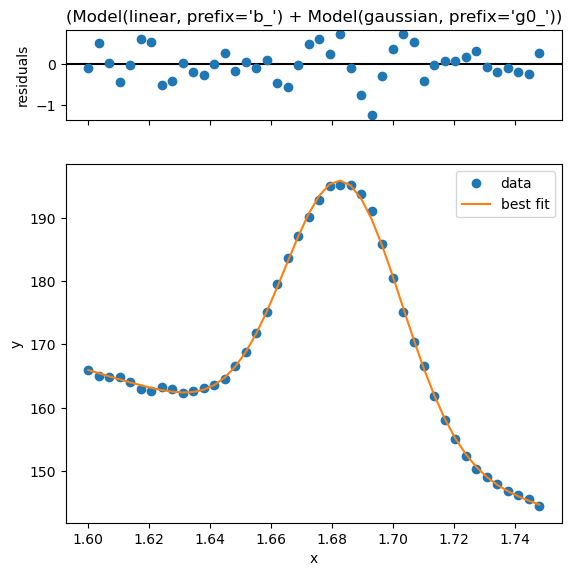

64
Figure(640x640)
chisqr is  9.838915417525186
x_motor and y motor are: (105.0,64.5)
peak centers:  [1.6838112626667003]


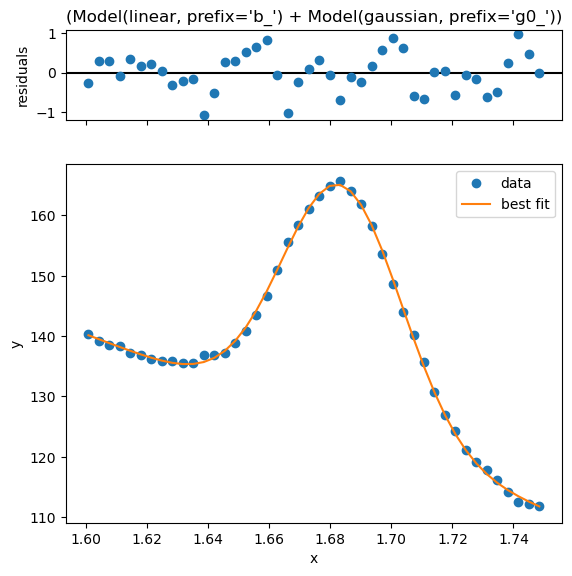

65
Figure(640x640)
chisqr is  7.151237371308452
x_motor and y motor are: (95.5,71.5)
peak centers:  [1.6833733777629047]


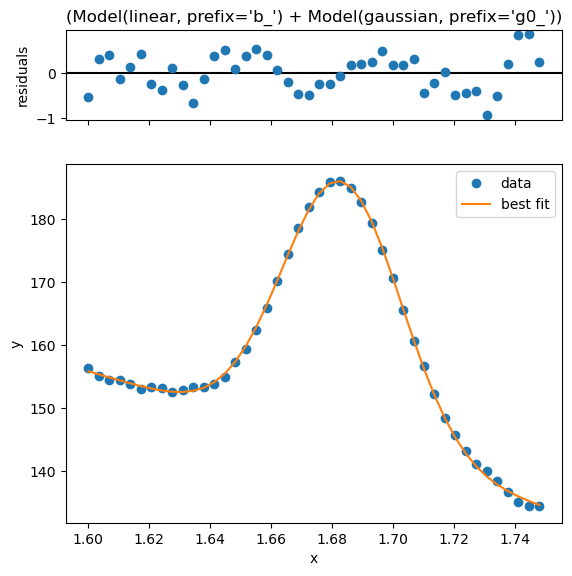

66
Figure(640x640)
chisqr is  5.1601702395846205
x_motor and y motor are: (100.0,71.0)
peak centers:  [1.6839318539775905]


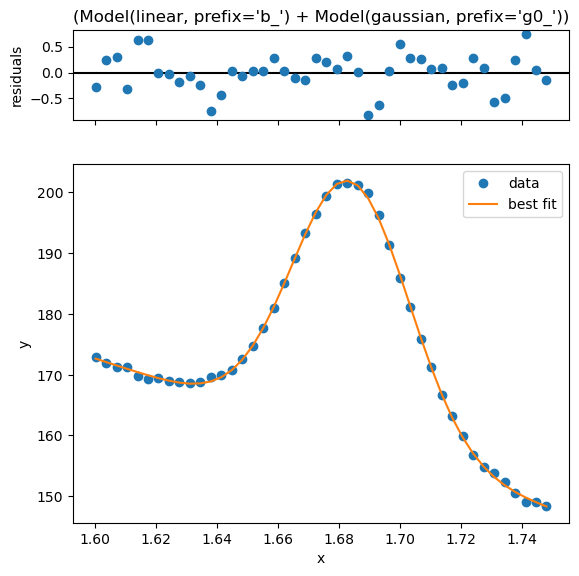

67
Figure(640x640)
chisqr is  9.76210210090862
x_motor and y motor are: (105.0,65.5)
peak centers:  [1.6839633052571037]


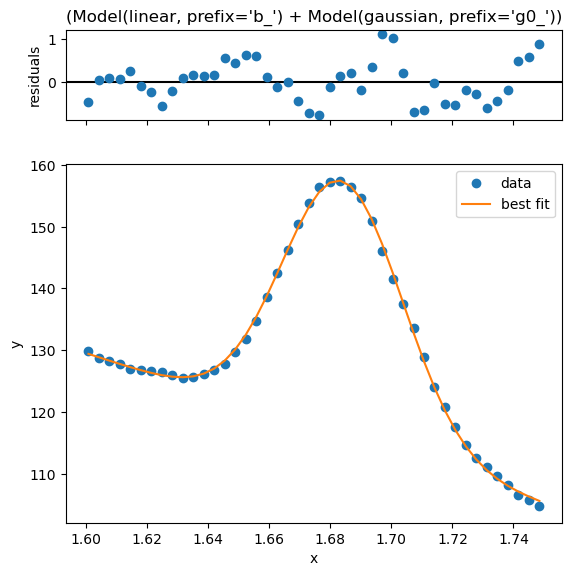

68
Figure(640x640)
chisqr is  5.493269114060596
x_motor and y motor are: (96.0,64.5)
peak centers:  [1.680834453365536, 1.7050964042171621]


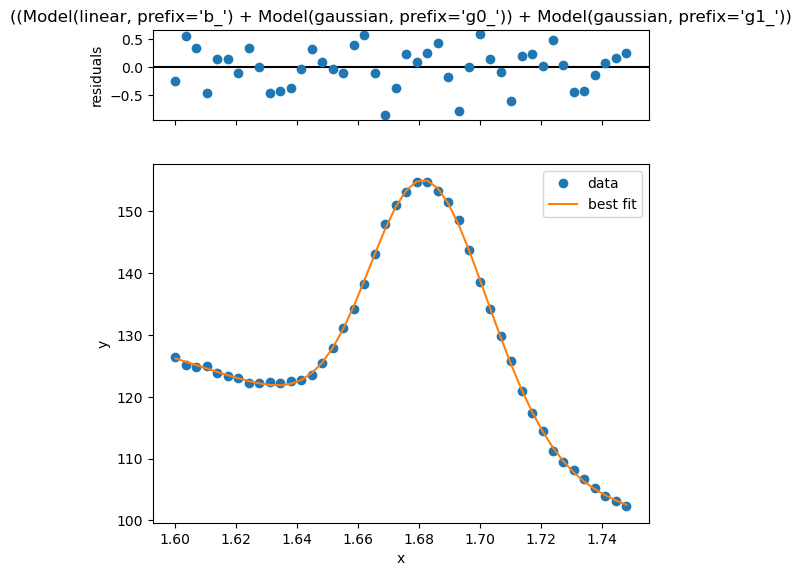

69
Figure(640x640)
chisqr is  5.422912715448684
x_motor and y motor are: (101.0,68.5)
peak centers:  [1.6854001162885035, 1.7001584907215586]


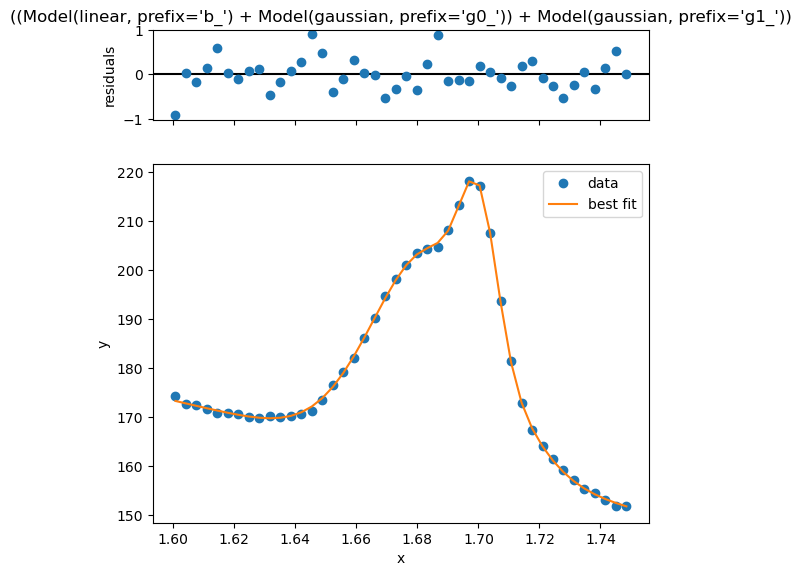

70
Figure(640x640)
chisqr is  9.897226283249987
x_motor and y motor are: (96.0,66.5)
peak centers:  [1.6844457437023332]


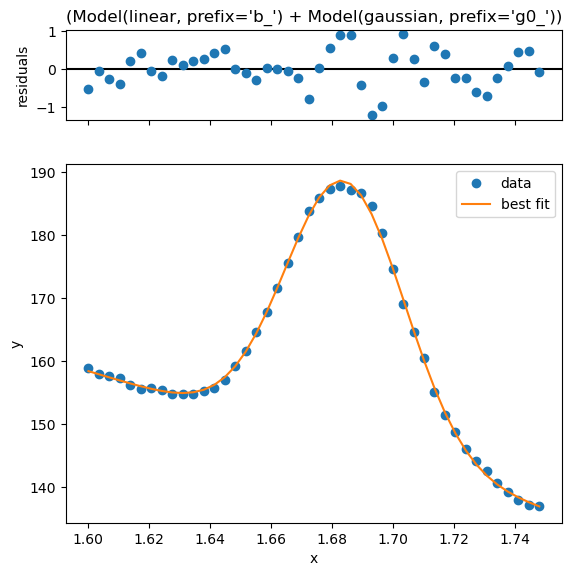

71
Figure(640x640)
chisqr is  8.510568325834752
x_motor and y motor are: (90.5,68.0)
peak centers:  [1.6838142277342252]


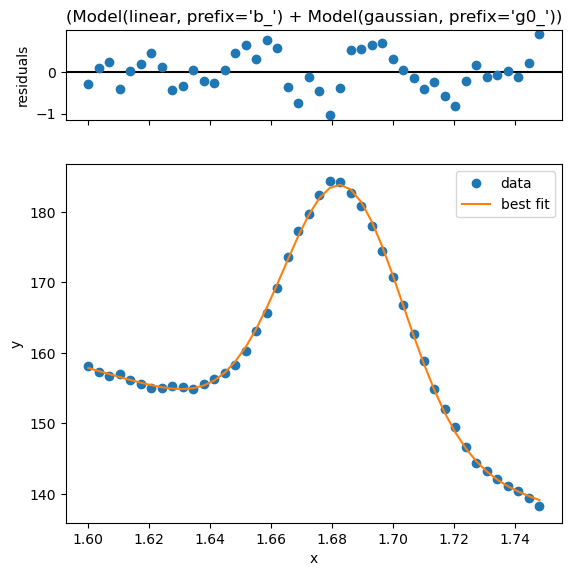

72
Figure(640x640)
chisqr is  6.478528479923346
x_motor and y motor are: (99.0,64.5)
peak centers:  [1.6901633593450007, 1.6833664973969804]


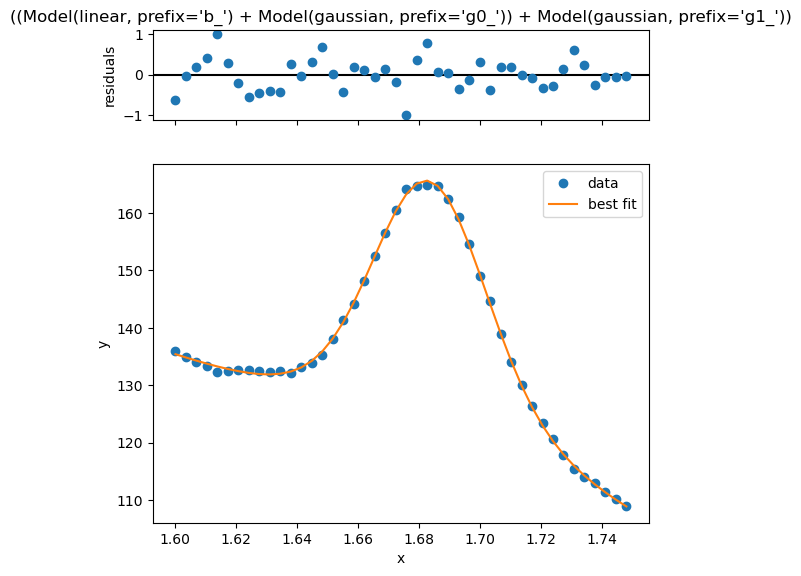

73
Figure(640x640)
chisqr is  7.369348371825968
x_motor and y motor are: (94.0,71.0)
peak centers:  [1.6836129597266176]


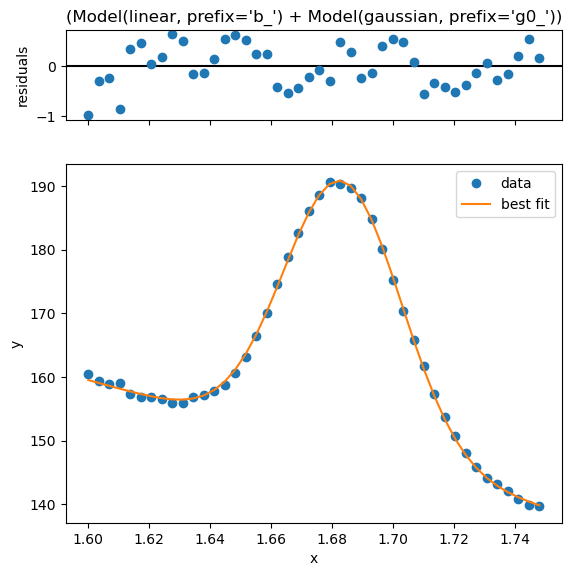

74
Figure(640x640)
chisqr is  6.327635196099661
x_motor and y motor are: (90.5,71.5)
peak centers:  [1.695391061168972, 1.688001454393444, 1.675527859144846]


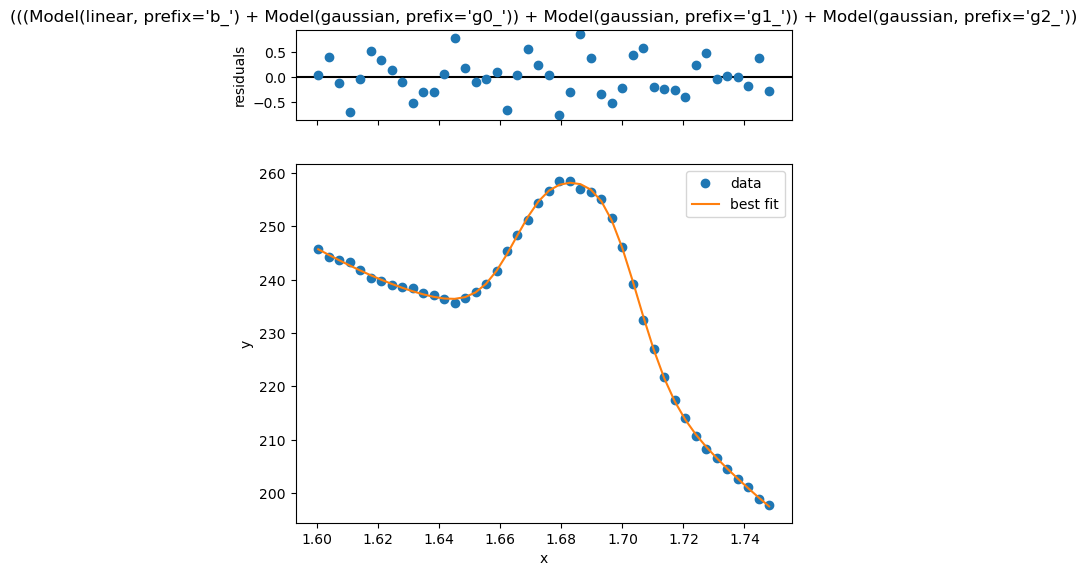

75
Figure(640x640)
chisqr is  7.49382092486839
x_motor and y motor are: (105.5,71.0)
peak centers:  [1.6321789021345454, 1.6833712892390509, 1.698921758972729]


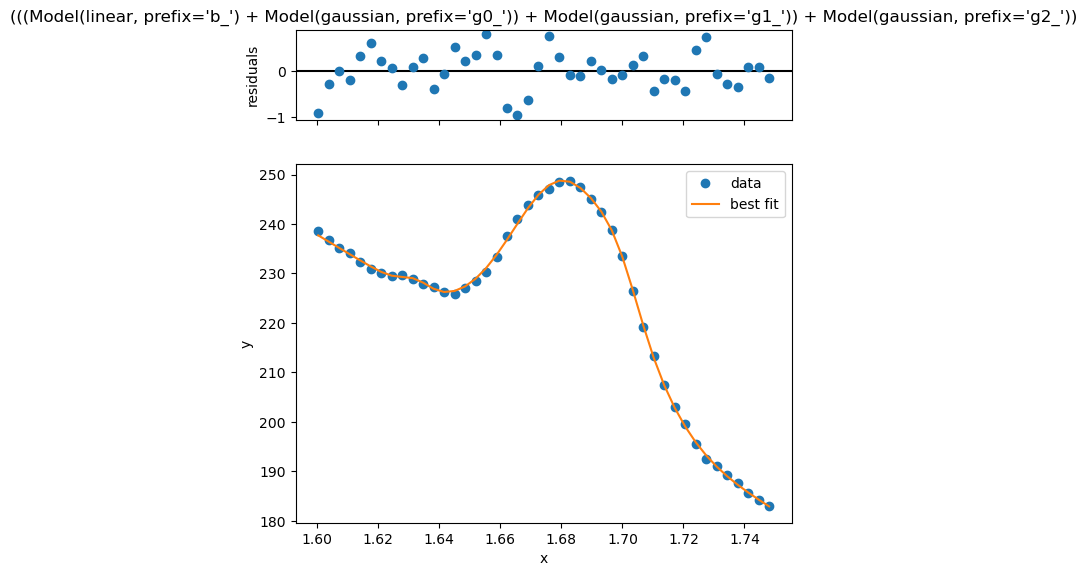

76
Figure(640x640)
chisqr is  4.341118145925452
x_motor and y motor are: (99.0,68.0)
peak centers:  [1.685524864150592, 1.699878892119734]


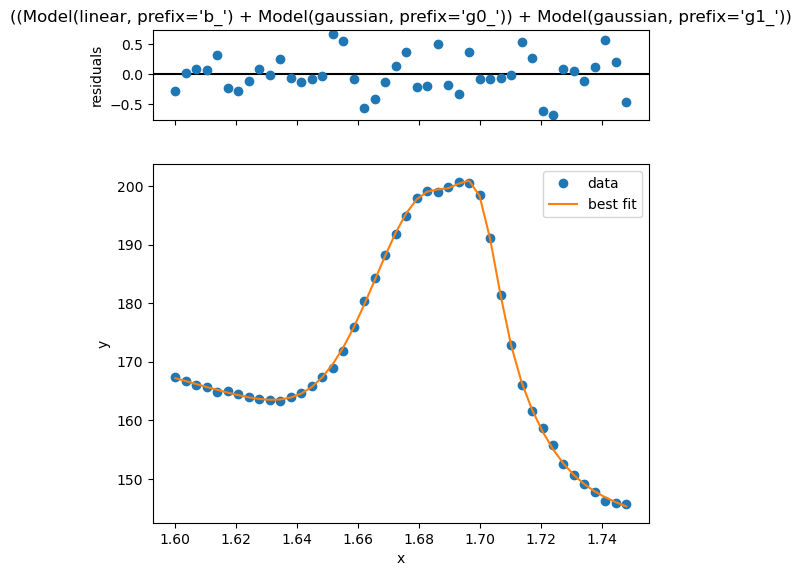

77
Figure(640x640)
chisqr is  8.501669758847878
x_motor and y motor are: (91.0,66.0)
peak centers:  [1.6839308128924932]


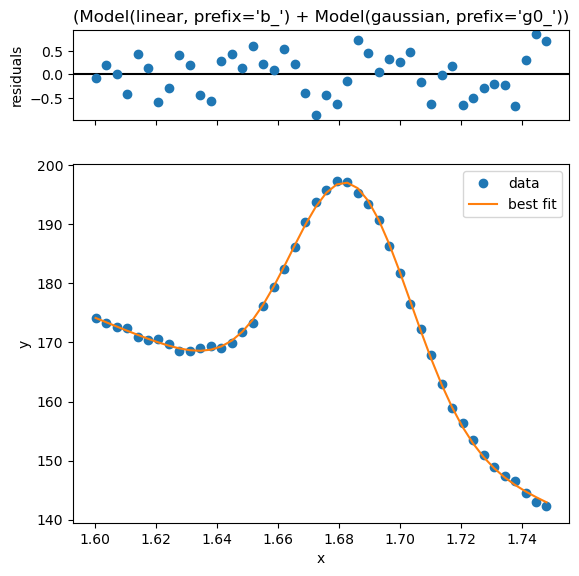

78
Figure(640x640)
chisqr is  5.488485211632223
x_motor and y motor are: (97.5,67.0)
peak centers:  [1.6855725104445316, 1.6715690830592407, 1.6924200418176756]


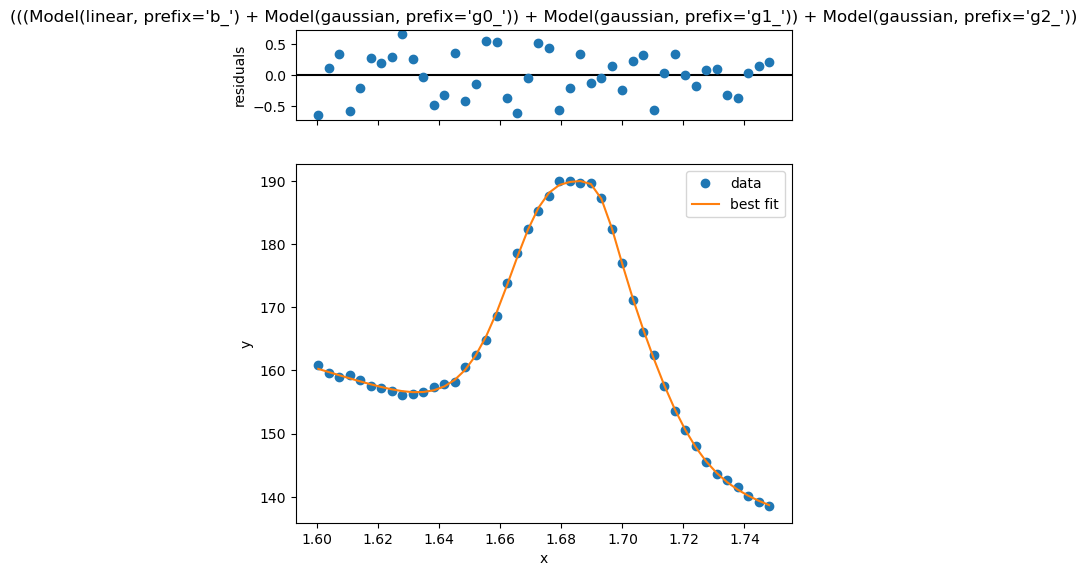

79
Figure(640x640)
chisqr is  9.164602379828482
x_motor and y motor are: (104.0,68.0)
peak centers:  [1.6839868921274899]


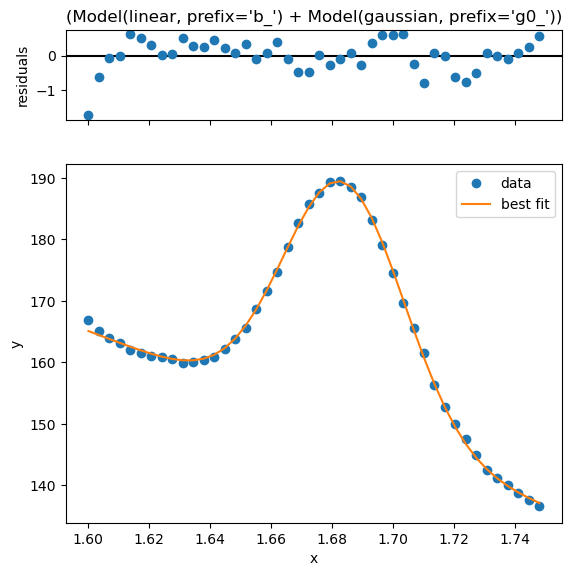

80
Figure(640x640)
chisqr is  5.428458701581483
x_motor and y motor are: (97.5,71.5)
peak centers:  [1.6833802660584596]


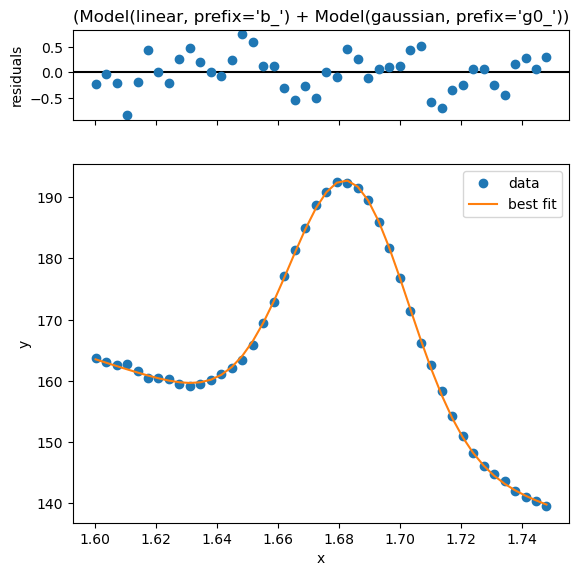

81
Figure(640x640)
chisqr is  8.884962153990584
x_motor and y motor are: (94.5,69.0)
peak centers:  [1.6696118244233702, 1.6840755326132038]


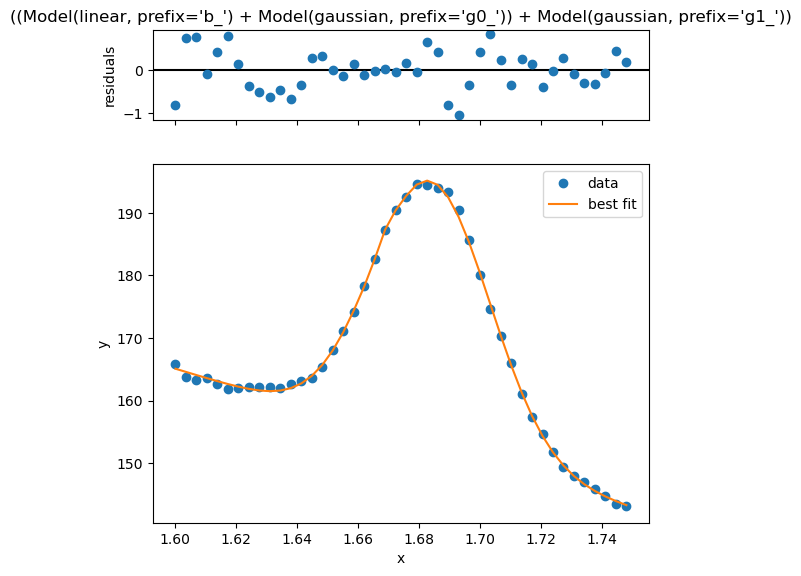

82
Figure(640x640)
chisqr is  7.556489771820314
x_motor and y motor are: (103.5,69.5)
peak centers:  [1.6835926068310518, 1.726685109717529]


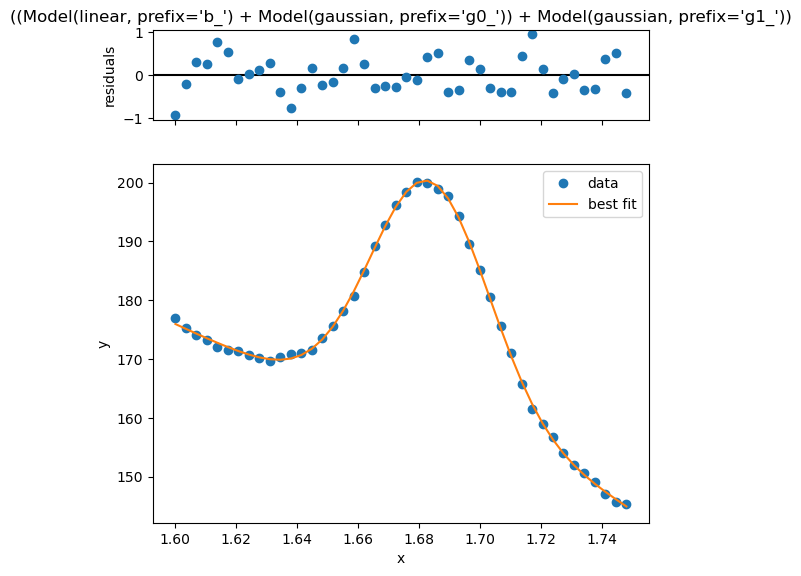

83
Figure(640x640)
chisqr is  7.098969501680312
x_motor and y motor are: (103.0,70.0)
peak centers:  [1.6852896882951078, 1.6984016219390312]


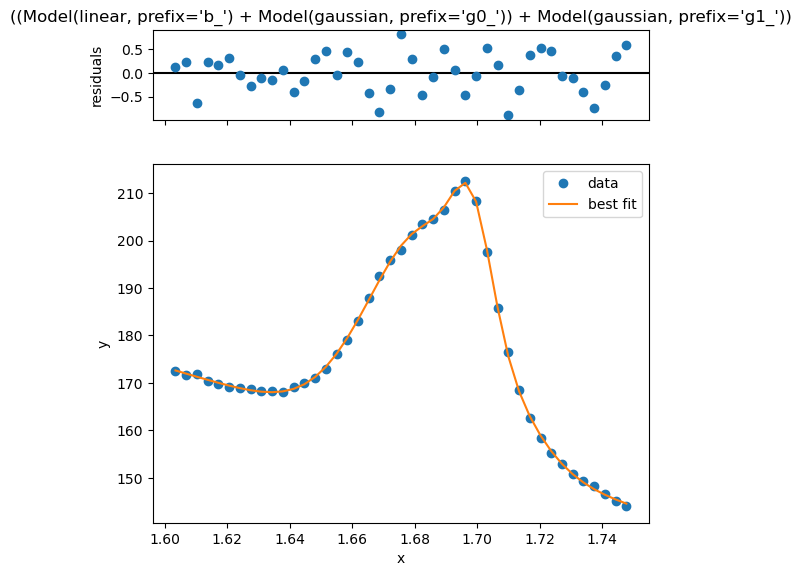

84
Figure(640x640)
chisqr is  9.335614436987333
x_motor and y motor are: (95.5,65.0)
peak centers:  [1.6841913650870717]


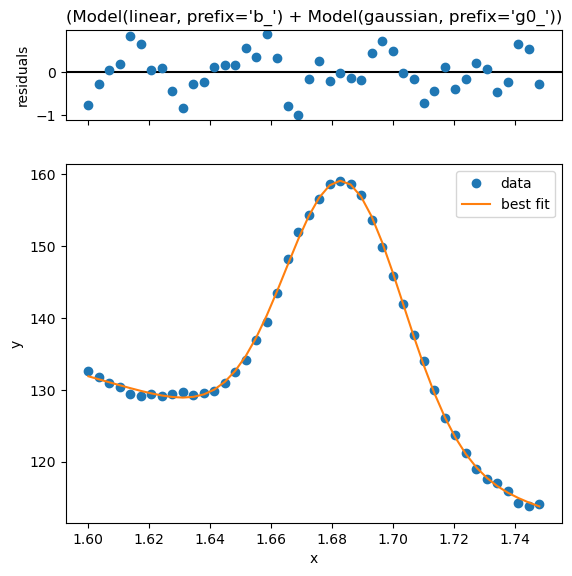

85
Figure(640x640)
chisqr is  7.896624351480503
x_motor and y motor are: (90.0,67.0)
peak centers:  [1.6834598985597737]


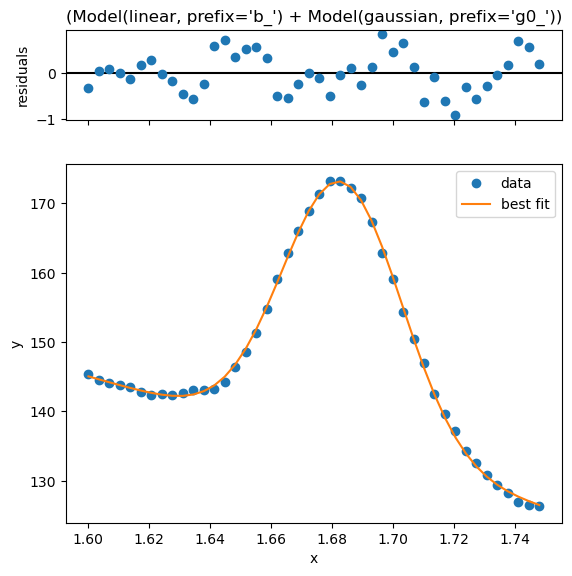

86
Figure(640x640)
chisqr is  8.022243713962668
x_motor and y motor are: (99.0,64.5)
peak centers:  [1.6996367499211258, 1.6831745233089368]


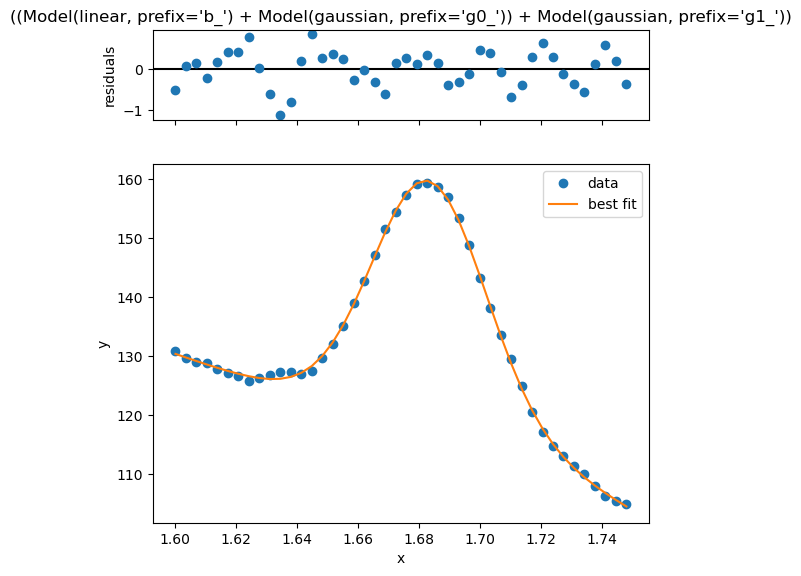

87
Figure(640x640)
chisqr is  6.393623285502674
x_motor and y motor are: (101.0,71.0)
peak centers:  [1.6833515874091474, 1.6926953624394903]


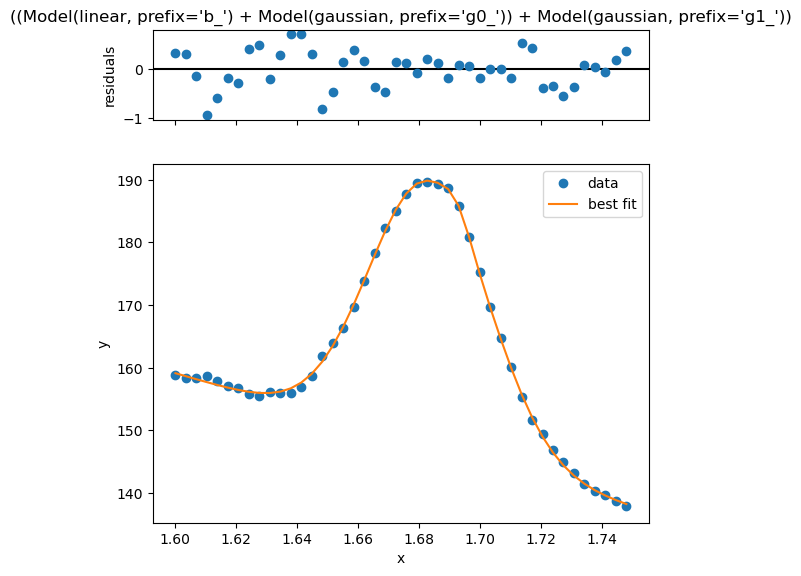

88
Figure(640x640)
chisqr is  5.693989284988478
x_motor and y motor are: (96.0,71.5)
peak centers:  [1.6793117142598484, 1.6862217793673522]


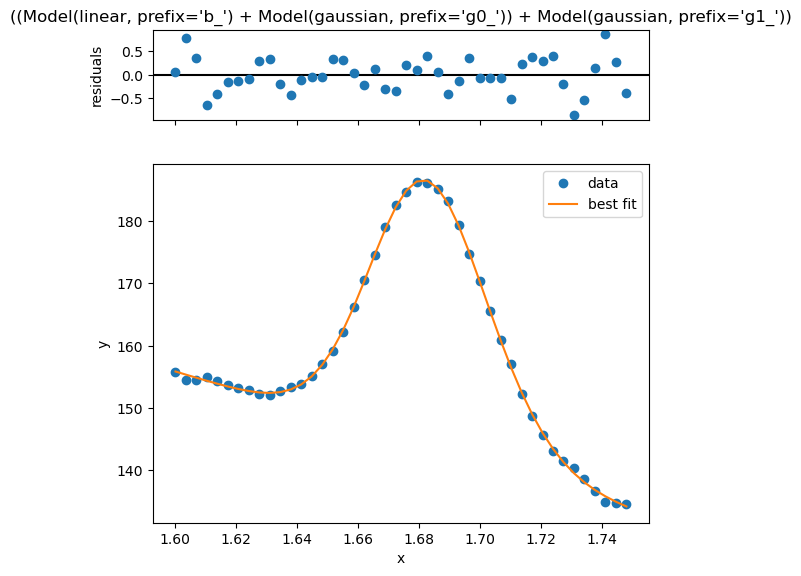

89
Figure(640x640)
chisqr is  7.854327152245518
x_motor and y motor are: (91.0,64.5)
peak centers:  [1.6829479147812445]


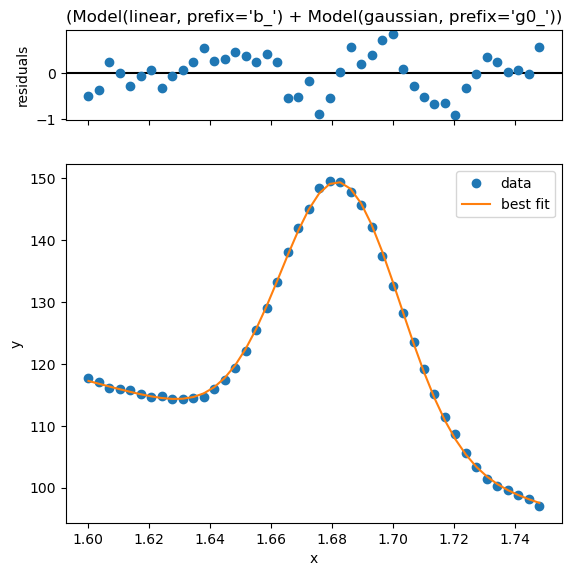

90
Figure(640x640)
chisqr is  6.207177323138393
x_motor and y motor are: (89.5,65.5)
peak centers:  [1.6792587711744724, 1.685502650519037]
THE THING HAPPENED MORE PEAKS


 fit not found
The chisqr is  26.9942499269391


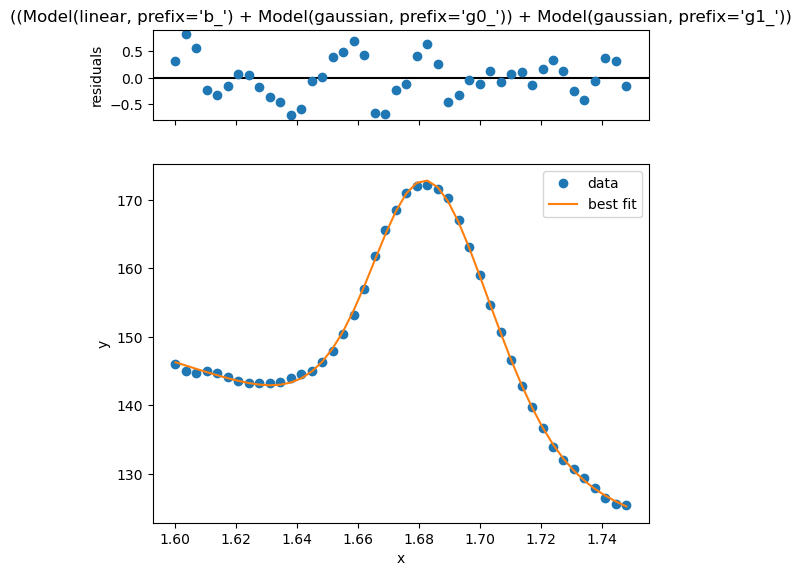

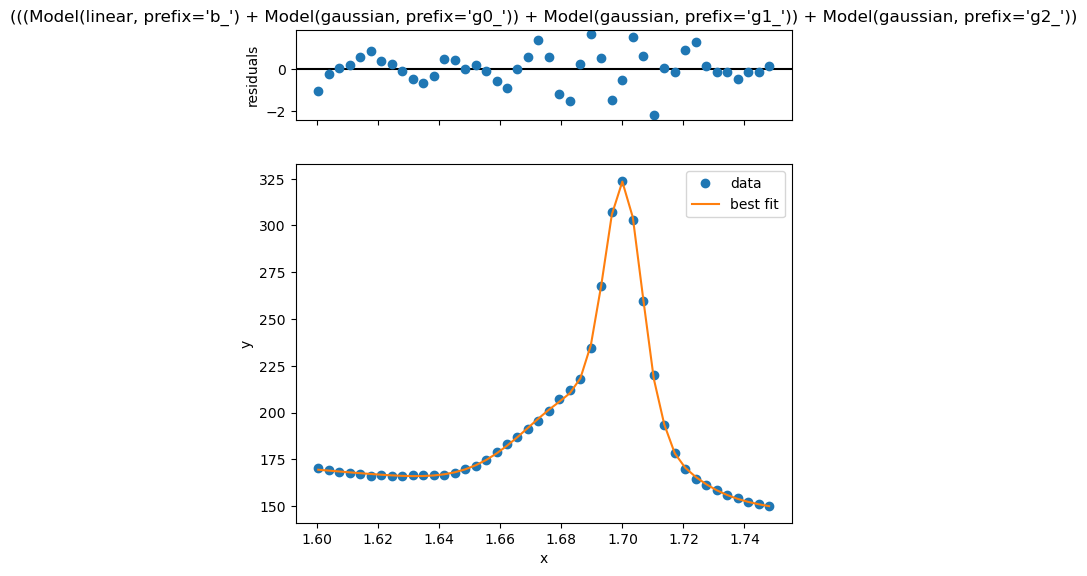

if its good enter y
y
chi squared: 26.9942499269391
91
Figure(640x640)
chisqr is  26.9942499269391
x_motor and y motor are: (102.0,67.5)
peak centers:  [1.6898275295022953, 1.7152449662712492, 1.700341481666348]
THE THING HAPPENED MORE PEAKS


 fit not found
The chisqr is  21.78446387208928


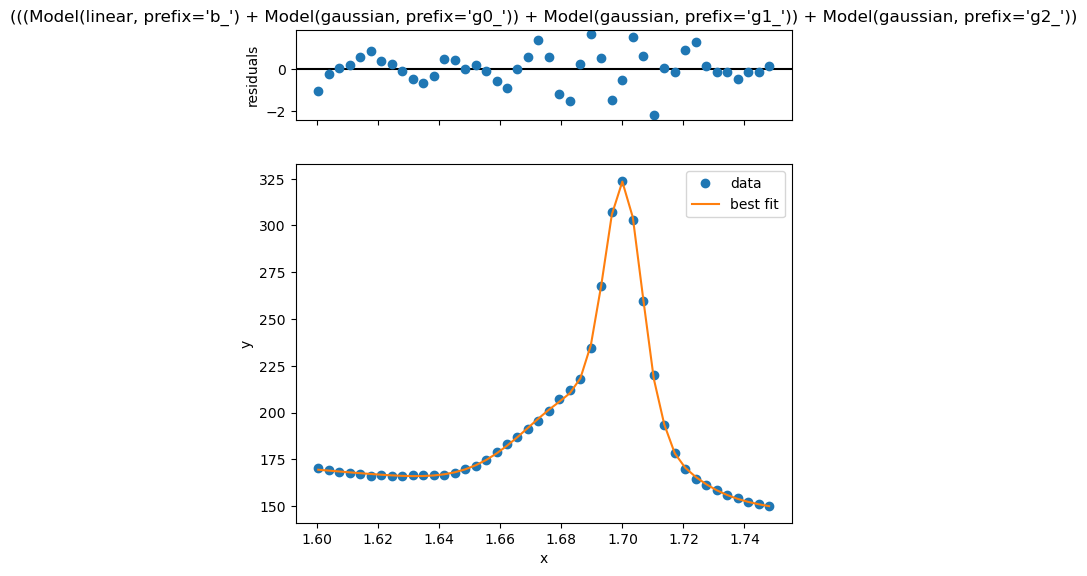

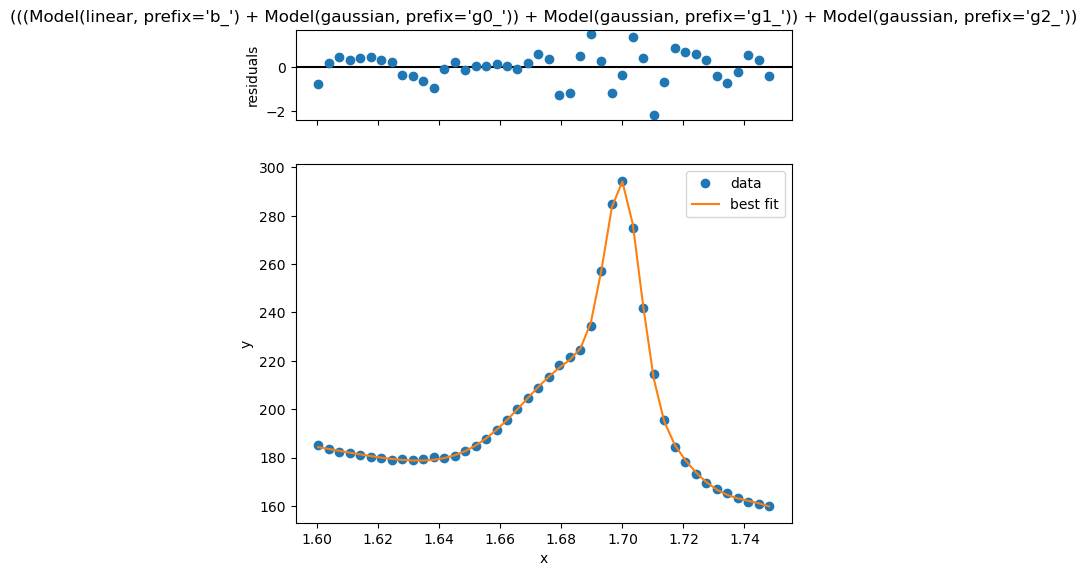

KeyboardInterrupt: Interrupted by user

In [17]:
startTime = time.time()

# Sample info
sample_name =   # CHARGED'S1_LN_10psi_Ch10_0120922_map_01-4'

# numper of centers to try
num_of_centers = 8

# the range you want lmift to use for centers for a lithium peak. 
Li_q_max = 2.525
Li_q_min = 2.54

#Setup dataframe 
df_integrals = pd.DataFrame(columns=['Sample', 'file_name', 'x motor', 'y motor',  'Gaussian1', 'FWHM1', 'Center1',
                                     'Gaussian2', 'FWHM2', 'Center2', 'Gaussian3', 'FWHM3', 'Center3'])
# path to all the tiff files
general_input_folder = r'D:\NSLS-II Winter 2023'
input_folder = os.path.join(general_input_folder, sample_name, 'integration')

general_output_folder = r'C:\Users\Elizabeth Allan-Cole\Desktop\XRD Data Processing\NSLS-II Winter 2023\Processing\Initial_fit'
output_folder = os.path.join(general_output_folder,  'Output',  sample_name)
plot_folder = os.path.join(general_output_folder, 'Plot Output')

# if that folder dosn't exist make it exist
if not os.path.exists(output_folder):
     os.makedirs(output_folder)

#Set isolated peak q range dict: [q_min, q_max, chi squared, sigma, amplitude]
#q_range_dict = {'Graphite-LixC6':[1.75, 1.9, 1000, 0.1, 150], 'NMC':[1.25, 1.36, 5000, 0.2, 500], 'Li': [2.49, 2.55, 10, 0.05, 1]}
#q_range_dict = {'Graphite-LixC6':[1.75, 1.9, 50, 0.1, 100], 'NMC':[1.25, 1.36, 30000, 0.1, 1000], 'Li': [2.49, 2.55, 10, 0.05, 1]}
#q_range_dict = {'Graphite-LixC6':[1.6, 1.9, 50, 0.1, 100], 'Li': [2.45, 2.57, 2, 0.05, 1]}

# Graphite/LiC12 only
#q_range_dict = {'Graphite-LixC6':[1.75, 1.9, 50, 0.1, 100]}

# LiC6 only
#q_range_dict = {'LiC6':[1.6, 1.75, 10, 0.1, 100]}

# nmc peaks only
#q_range_dict = {'NMC':[1.25, 1.36, 150, 0.1, 1500]}

# Li peaks only
#q_range_dict = {'Li': [2.45, 2.57, 2, 0.05, 1]}

# Make a list of all files names in folder
list_of_files = [files for files in listdir(input_folder) if isfile(join(input_folder, files))]


for element in q_range_dict.keys():
    df_integrals_temp = pd.DataFrame(columns=['Sample', 'file_name', 'x motor', 'y motor',  'Gaussian1', 'FWHM1', 'Center1',
                                     'Gaussian2', 'FWHM2', 'Center2', 'Gaussian3', 'FWHM3', 'Center3'])
    q_min = q_range_dict.get(element)[0]
    q_max = q_range_dict.get(element)[1]
    sig = q_range_dict.get(element)[3]
    amp =q_range_dict.get(element)[4]
    chisqu_fit_value = q_range_dict.get(element)[2]
    print("finding ", element, " peaks! Hold on to your socks!")
    print("qmax is " ,q_min, "q min is ", q_max)

    n = 0
    # loop through the list of files and append df_integrals --> Troubleshoot the peak fitting, getting weird numbers! 
    for i in range(len(list_of_files)): 
        if 'mean_q' in list_of_files[i]:
            
            #Call the master function to get the integral values for the specified peak
            # returns [sample_name, x_motor, y_motor, integral_list, fwhm_list, peak_center_list, best_model]
            get_integrals = master_function(list_of_files[i], num_of_centers, input_folder, q_min, q_max, 
                                            sample_name, sig, amp, chisqu_fit_value, element, Li_q_max, Li_q_min)
            
            
            # save the plots for the best fit if you want
            save_fits(plot_folder, get_integrals, element, list_of_files, i, sample_name)
            
            
            # this just prints the number of files we've cronked through
            print(n)
            n += 1
            
            # uncomment me to see the fits!! Comment out for processing the whole data set. 
            print(get_integrals[6].plot())
            print('chisqr is ', get_integrals[6].chisqr)
            print('x_motor and y motor are: (' + str(get_integrals[1]) + ',' + str(get_integrals[2]) + ')')
            
            
            
            # zips the integral_list, fwhm_list, peak_center_list together to make a list of lists
            # ie ((integral_1, fwhm_1, center_1), (integral_2, fwhm_2, center_2))
            vals_list = list(zip(get_integrals[3], get_integrals[4], get_integrals[5]))
            print('peak centers: ', get_integrals[5])
            
            #flatten the list to just a list (integral_1, fwhm_1, center_1, integral_2, fwhm_2, center_2)
            vals_list = [item for sublist in vals_list for item in sublist]
            
            
            # add the sample and position info sample_name, x_motor, y_motor
            info_list = [get_integrals[0], get_integrals[1], get_integrals[2]]
            # add the filename 
            info_list.insert(1, list_of_files[i])
            # add then together
            info_list = info_list + vals_list
            # Find the number of nan vales we add to make this list have 12 values so we can slap it in a dataframe
            num_nans = df_integrals_temp.shape[1] - len(info_list)
            
            # Add a bunch of nans
            x = 0
            while x < num_nans:
                info_list.append(np.nan)
                x += 1
                
            # find the last row in the df    
            max_row = df_integrals_temp.shape[0]
            # slap our list of values in the dataframe!
            df_integrals_temp.loc[max_row + 1,] = info_list
            
            
    # after each peak is run save the data frame
    file_name = str(get_integrals[0] + '_' + element + '.csv')
    output_file = os.path.join(output_folder, file_name)
    df_integrals_temp.to_csv(output_file)

    # add data to the master data frame
    if df_integrals.empty:
        df_integrals = df_integrals_temp
    else:
        df_integrals = pd.concat([df_integrals, df_integrals_temp])

# save the master dataframe
file_name = str(get_integrals[0]) + '_all_data.csv'
output_file = os.path.join(output_folder, file_name)
df_integrals.to_csv(output_file)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

In [ ]:
print("IM DONE")

In [ ]:
print( df_integrals)

# To do: 
- Make fitting faster/ optimize the fitting algorithem 
- Fit the NMC peak
- Fit the background for the Li peak
- Deconvolute the peaks so we can see how they are individually contributing to the model 
- Figure out Voight model
- Better background models for other peaks
- Figure our how to distinguish the stages of grphite (i.e. q between 1.75 and 1.87)

In [ ]:
def plot_peaks ():
    
    #comps = result.eval_components(x=x) 
    
    x = 
    
    fig, ax = plt.subplots(1,1, figsize=(7,7))

    for 
        ax.plot(x,y, label='Data')
        ax.plot(x,result.best_fit, label='Model')
        ax.plot(x, comps[b+'_'], '--', label='Linear')
        ax.plot(x, comps[p1+'_'], '--', label='NMC(101)')
        ax.plot(x, comps[p2+'_'], '--', label='NMC(006)')
        ax.plot(x, comps[p3+'_'], '--', label='NMC(102)')
        ax.plot(x, comps[p4+'_'], '--', label='Al(111)')

        ax.set_xlim(q_min, q_max)
        ax.set_title('NMC(101),(006),(102); Al(111): ('+ str(x_motor) + ',' + str(y_motor) + ')') 
        ax.set_xlabel('q [1/A]')
        ax.set_ylabel('I [au.]')
        ax.legend()